<a href="https://colab.research.google.com/github/juanrueda5/Magnetic-Domains-With-Machine-Learning/blob/main/CNNTorch_MagDom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 2.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
!pip install torcheval

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
import numpy as np
import cv2
import io
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import zipfile
import PIL

In [ ]:

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from tqdm import tqdm
cudnn.benchmark = True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
from tempfile import TemporaryDirectory

# **Define Device**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Transformations**

In [ ]:
data_transforms = {
    'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(),
            transforms.Resize((450, 450)),
            transforms.ToTensor(),
            ]),
    'val': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize((450, 450)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            ]),
}

# **Image Augmentation**

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image

# Define the directory for the input and output images
input_dir = '/content/drive/MyDrive/CroppedImages/val/'
output_dir = '/content/drive/MyDrive/CroppedImages/trial/'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 1: Define transformations
my_transform = transforms.Compose([
    transforms.Resize((450, 450)),
    transforms.RandomCrop((360,360)),
    transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    transforms.RandomRotation(degrees=45),     # Random rotation
    transforms.ColorJitter(brightness = 0.5),
    transforms.RandomGrayscale(p=0.3),        # Random grayscale# Convert to tensor
])

list_img = os.listdir(input_dir)
for img in list_img:
  image = Image.open(input_dir + img)
  image = my_transform(image)
  image.save(output_dir + img.replace('.png','') + 'tr_.png')



KeyboardInterrupt: 

# **Read Images on ZipFiles**

In [ ]:
class ZipDataset():
    def __init__(self, root_path, var,trns, cache_into_memory=False):
        if cache_into_memory:
            f = open(root_path, 'rb')
            self.zip_content = f.read()
            f.close()
            self.zip_file = zipfile.ZipFile(io.BytesIO(self.zip_content), 'r')
        else:
            self.zip_file = zipfile.ZipFile(root_path, 'r')
        self.name_list = list(filter(lambda x: var in x, self.zip_file.namelist()))
        self.to_tensor = ToTensor()
        self.transf = trns[var]
    def __getitem__(self, key):
        buf = self.zip_file.read(name=self.name_list[key])
        img = cv2.imdecode(np.frombuffer(buf, dtype=np.uint8), cv2.IMREAD_COLOR)
        img = PIL.Image.fromarray(img)
        values = self.name_list[key].split('_')
        Ms = float(values[0].split('/')[-1])
        Aex = float(values[1])
        keff = float(values[2])
        alpha = float(values[3])
        maxMs = 1900000.0
        maxAex = 2.4999999999999998e-11
        maxkeff = 1000000.0
        maxalpha = 0.95
        target = [Ms/maxMs, Aex/maxAex, keff/maxkeff, alpha/maxalpha]
        target = torch.tensor(target, dtype=torch.float32)
        img = self.transf(img)
        return img, target

    def __len__(self):
        return len(self.name_list)

In [ ]:
path1= '/content/drive/MyDrive/FinalDataMD/CroppedImages.zip'
ZipDataset(root_path=path1, var='train', trns=data_transforms).__getitem__(0)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([1.0000, 1.0000, 0.4000, 1.0000]))

In [ ]:
num_steps = 100
batch_size =64
num_epochs = 200

dtype = torch.float# Torch Variables

In [ ]:
dataset_train = ZipDataset(root_path = path1,var='train', trns = data_transforms, cache_into_memory=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = ZipDataset(path1,var='val',trns = data_transforms,cache_into_memory=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
image_datasets = {'train': dataset_train, 'val': dataset_val}
dataloaders = {'train': dataloader_train, 'val': dataloader_val}
dataset_sizes = {'train': len(image_datasets['train']),'val': len(image_datasets['val'])}
print(dataset_sizes)

{'train': 406, 'val': 106}


In [ ]:
net = nn.Sequential(nn.Conv2d(1, 32, 7),
                    nn.MaxPool2d(2),
                    nn.Conv2d(32, 64, 5),
                    nn.MaxPool2d(2),
                    nn.Conv2d(64, 128, 3),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(128, 256),
                    nn.Linear(256,128),
                    nn.Linear(128,64),
                    nn.Linear(64,4),
                    ).to(device)

# **Optimizer, Scheduler, Loss**

In [ ]:
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
scheduler = lr_scheduler.MultiStepLR(optimizer,
                        milestones=[8, 24, 28], # List of epoch indices
                        gamma =0.5) # Multiplicative factor of learning rate decay

# **Train Loop**

In [ ]:
from torcheval.metrics import R2Score
R2list = []
MAElist = []
losslist = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=500):
    R2 = R2Score()
    MAE = nn.L1Loss()
    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_R2 = -1000000000000000.0
        best_MAE = 100000000000000.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase],leave=False):
                    try:
                      inputs = inputs.to(device)
                      labels = labels.to(device)

                      # zero the parameter gradients
                      optimizer.zero_grad()

                      # forward
                      # track history if only in train
                      with torch.set_grad_enabled(phase == 'train'):
                          outputs = model(inputs)
                          _, preds = torch.max(outputs, 0)
                          loss = criterion(outputs, labels)

                          # backward + optimize only if in training phase
                          if phase == 'train':
                              loss.backward()
                              optimizer.step()
                    except Exception as e:
                      pass
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                epoch_loss = running_loss / dataset_sizes[phase]
                R2.update(outputs, labels)
                epoch_R2 = R2.compute()
                epoch_MAE = MAE(outputs, labels)
                R2list.append(epoch_R2)
                losslist.append(epoch_loss)
                MAElist.append(epoch_MAE)
                print(f'{phase} Loss: {epoch_loss:.4f} R2Score: {epoch_R2:.4f} MAE: {epoch_MAE:.4f}')

                # deep copy the model
                if phase == 'val':
                  if epoch_R2 > best_R2:
                    best_R2 = epoch_R2
                    torch.save(model.state_dict(), best_model_params_path)
                  if epoch_MAE < best_MAE:
                    best_MAE = epoch_MAE
            print()
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val R2: {best_R2:4f}', best_R2)
        print(f'Best val MAE: {best_MAE:4f}')

        # load best model weights

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
param_path='/content/drive/MyDrive/MagDomWeights/MagDom2paramHuber500epochR2filersize5_5.pth'
trained_net = train_model(net,criterion,optimizer,scheduler)
torch.save(trained_net.state_dict(),param_path )

Epoch 0/499
----------


train Loss: 70.6683 R2Score: -846280.6250 MAE: 168.5430


val Loss: 75.9392 R2Score: -366664.4062 MAE: 70.9576

Epoch 1/499
----------


train Loss: 33.5290 R2Score: -267072.1562 MAE: 5.1495


val Loss: 9.3924 R2Score: -185993.2188 MAE: 10.3825

Epoch 2/499
----------


train Loss: 7.9253 R2Score: -159687.3594 MAE: 5.7347


val Loss: 4.1498 R2Score: -124417.1719 MAE: 4.6231

Epoch 3/499
----------


train Loss: 3.4338 R2Score: -113991.1406 MAE: 4.6124


val Loss: 1.5119 R2Score: -95563.9844 MAE: 2.0057

Epoch 4/499
----------


train Loss: 1.9134 R2Score: -88232.8438 MAE: 0.9442


val Loss: 0.6284 R2Score: -75897.7266 MAE: 1.0441

Epoch 5/499
----------


train Loss: 0.3843 R2Score: -71970.6172 MAE: 0.6771


val Loss: 0.3952 R2Score: -64591.3984 MAE: 0.7889

Epoch 6/499
----------


train Loss: 0.1866 R2Score: -60942.9375 MAE: 0.3433


val Loss: 0.0660 R2Score: -54762.2578 MAE: 0.2966

Epoch 7/499
----------


train Loss: 0.0752 R2Score: -52541.1680 MAE: 0.2982


val Loss: 0.0620 R2Score: -48461.6602 MAE: 0.2829

Epoch 8/499
----------


train Loss: 0.0607 R2Score: -46534.8672 MAE: 0.2629


val Loss: 0.0448 R2Score: -43192.8984 MAE: 0.2382

Epoch 9/499
----------


train Loss: 0.0369 R2Score: -41347.9844 MAE: 0.2271


val Loss: 0.0350 R2Score: -38596.5508 MAE: 0.2215

Epoch 10/499
----------


train Loss: 0.0316 R2Score: -37380.9141 MAE: 0.1720


val Loss: 0.0293 R2Score: -35070.8086 MAE: 0.2137

Epoch 11/499
----------


train Loss: 0.0283 R2Score: -34017.3516 MAE: 0.1835


val Loss: 0.0263 R2Score: -32267.0078 MAE: 0.1803

Epoch 12/499
----------


train Loss: 0.0254 R2Score: -31372.9238 MAE: 0.1697


val Loss: 0.0250 R2Score: -29832.4023 MAE: 0.1765

Epoch 13/499
----------


train Loss: 0.0243 R2Score: -28994.0742 MAE: 0.1801


val Loss: 0.0245 R2Score: -27738.8594 MAE: 0.1638

Epoch 14/499
----------


train Loss: 0.0233 R2Score: -27079.6113 MAE: 0.1693


val Loss: 0.0245 R2Score: -25852.1016 MAE: 0.1829

Epoch 15/499
----------


train Loss: 0.0235 R2Score: -25292.6328 MAE: 0.1664


val Loss: 0.0242 R2Score: -24237.5898 MAE: 0.1889

Epoch 16/499
----------


train Loss: 0.0228 R2Score: -23809.9375 MAE: 0.1567


val Loss: 0.0250 R2Score: -22900.6016 MAE: 0.1803

Epoch 17/499
----------


train Loss: 0.0233 R2Score: -22422.9941 MAE: 0.1659


val Loss: 0.0238 R2Score: -21621.0879 MAE: 0.1717

Epoch 18/499
----------


train Loss: 0.0228 R2Score: -21209.3457 MAE: 0.1753


val Loss: 0.0238 R2Score: -20479.4434 MAE: 0.1875

Epoch 19/499
----------


train Loss: 0.0227 R2Score: -20221.2910 MAE: 0.1447


val Loss: 0.0241 R2Score: -19567.5117 MAE: 0.1806

Epoch 20/499
----------


train Loss: 0.0227 R2Score: -19217.9492 MAE: 0.1904


val Loss: 0.0239 R2Score: -18641.0078 MAE: 0.1751

Epoch 21/499
----------


train Loss: 0.0227 R2Score: -18337.9961 MAE: 0.1944


val Loss: 0.0241 R2Score: -17749.5312 MAE: 0.1866

Epoch 22/499
----------


train Loss: 0.0231 R2Score: -17496.5098 MAE: 0.1769


val Loss: 0.0246 R2Score: -16981.4121 MAE: 0.1914

Epoch 23/499
----------


train Loss: 0.0229 R2Score: -16741.0820 MAE: 0.1638


val Loss: 0.0234 R2Score: -16260.9766 MAE: 0.1733

Epoch 24/499
----------


train Loss: 0.0224 R2Score: -16050.4180 MAE: 0.1532


val Loss: 0.0239 R2Score: -15601.3994 MAE: 0.1841

Epoch 25/499
----------


train Loss: 0.0226 R2Score: -15357.5596 MAE: 0.1828


val Loss: 0.0238 R2Score: -14959.1445 MAE: 0.1807

Epoch 26/499
----------


train Loss: 0.0228 R2Score: -14790.0674 MAE: 0.1560


val Loss: 0.0256 R2Score: -14441.7363 MAE: 0.1869

Epoch 27/499
----------


train Loss: 0.0233 R2Score: -14268.9082 MAE: 0.1670


val Loss: 0.0237 R2Score: -13925.0020 MAE: 0.1696

Epoch 28/499
----------


train Loss: 0.0225 R2Score: -13776.6729 MAE: 0.1585


val Loss: 0.0238 R2Score: -13436.4023 MAE: 0.1881

Epoch 29/499
----------


train Loss: 0.0224 R2Score: -13270.3691 MAE: 0.1782


val Loss: 0.0237 R2Score: -12982.6035 MAE: 0.1694

Epoch 30/499
----------


train Loss: 0.0223 R2Score: -12833.9492 MAE: 0.1734


val Loss: 0.0235 R2Score: -12552.9258 MAE: 0.1766

Epoch 31/499
----------


train Loss: 0.0225 R2Score: -12405.4062 MAE: 0.1746


val Loss: 0.0241 R2Score: -12148.2822 MAE: 0.1725

Epoch 32/499
----------


train Loss: 0.0228 R2Score: -11995.8545 MAE: 0.1832


val Loss: 0.0236 R2Score: -11768.3252 MAE: 0.1661

Epoch 33/499
----------


train Loss: 0.0228 R2Score: -11663.8613 MAE: 0.1615


val Loss: 0.0238 R2Score: -11436.7598 MAE: 0.1795

Epoch 34/499
----------


train Loss: 0.0230 R2Score: -11328.1484 MAE: 0.1767


val Loss: 0.0243 R2Score: -11091.9434 MAE: 0.1990

Epoch 35/499
----------


train Loss: 0.0226 R2Score: -10990.5195 MAE: 0.1740


val Loss: 0.0238 R2Score: -10786.5723 MAE: 0.1758

Epoch 36/499
----------


train Loss: 0.0226 R2Score: -10684.0957 MAE: 0.1616


val Loss: 0.0235 R2Score: -10489.3135 MAE: 0.1795

Epoch 37/499
----------


train Loss: 0.0223 R2Score: -10389.2051 MAE: 0.1673


val Loss: 0.0234 R2Score: -10214.7676 MAE: 0.1678

Epoch 38/499
----------


train Loss: 0.0222 R2Score: -10120.9131 MAE: 0.1621


val Loss: 0.0236 R2Score: -9946.4580 MAE: 0.1754

Epoch 39/499
----------


train Loss: 0.0224 R2Score: -9854.5537 MAE: 0.1748


val Loss: 0.0236 R2Score: -9685.8789 MAE: 0.1765

Epoch 40/499
----------


train Loss: 0.0223 R2Score: -9608.7021 MAE: 0.1596


val Loss: 0.0242 R2Score: -9461.2207 MAE: 0.1741

Epoch 41/499
----------


train Loss: 0.0226 R2Score: -9392.0439 MAE: 0.1671


val Loss: 0.0237 R2Score: -9232.4316 MAE: 0.1866

Epoch 42/499
----------


train Loss: 0.0225 R2Score: -9157.7051 MAE: 0.1688


val Loss: 0.0235 R2Score: -9019.7168 MAE: 0.1817

Epoch 43/499
----------


train Loss: 0.0226 R2Score: -8943.9072 MAE: 0.1792


val Loss: 0.0236 R2Score: -8813.9512 MAE: 0.1773

Epoch 44/499
----------


train Loss: 0.0223 R2Score: -8752.6035 MAE: 0.1655


val Loss: 0.0236 R2Score: -8621.2080 MAE: 0.1879

Epoch 45/499
----------


train Loss: 0.0225 R2Score: -8547.4980 MAE: 0.1993


val Loss: 0.0238 R2Score: -8423.5264 MAE: 0.1789

Epoch 46/499
----------


train Loss: 0.0225 R2Score: -8365.5605 MAE: 0.1612


val Loss: 0.0235 R2Score: -8248.8145 MAE: 0.1731

Epoch 47/499
----------


train Loss: 0.0223 R2Score: -8189.3066 MAE: 0.1602


val Loss: 0.0233 R2Score: -8075.6704 MAE: 0.1644

Epoch 48/499
----------


train Loss: 0.0222 R2Score: -8009.2803 MAE: 0.1921


val Loss: 0.0234 R2Score: -7901.3042 MAE: 0.1802

Epoch 49/499
----------


train Loss: 0.0224 R2Score: -7841.7920 MAE: 0.1667


val Loss: 0.0241 R2Score: -7741.6396 MAE: 0.1749

Epoch 50/499
----------


train Loss: 0.0225 R2Score: -7692.1357 MAE: 0.1535


val Loss: 0.0237 R2Score: -7597.2354 MAE: 0.1735

Epoch 51/499
----------


train Loss: 0.0224 R2Score: -7545.8545 MAE: 0.1713


val Loss: 0.0235 R2Score: -7449.9370 MAE: 0.1845

Epoch 52/499
----------


train Loss: 0.0222 R2Score: -7398.0825 MAE: 0.1770


val Loss: 0.0238 R2Score: -7304.8140 MAE: 0.1746

Epoch 53/499
----------


train Loss: 0.0223 R2Score: -7259.4961 MAE: 0.1727


val Loss: 0.0233 R2Score: -7170.1768 MAE: 0.1839

Epoch 54/499
----------


train Loss: 0.0222 R2Score: -7123.3770 MAE: 0.1671


val Loss: 0.0242 R2Score: -7038.6621 MAE: 0.1767

Epoch 55/499
----------


train Loss: 0.0227 R2Score: -6994.2554 MAE: 0.1672


val Loss: 0.0235 R2Score: -6912.4268 MAE: 0.1707

Epoch 56/499
----------


train Loss: 0.0221 R2Score: -6873.3647 MAE: 0.1711


val Loss: 0.0234 R2Score: -6793.5952 MAE: 0.1735

Epoch 57/499
----------


train Loss: 0.0223 R2Score: -6760.2612 MAE: 0.1494


val Loss: 0.0243 R2Score: -6682.5635 MAE: 0.1790

Epoch 58/499
----------


train Loss: 0.0230 R2Score: -6645.5439 MAE: 0.1707


val Loss: 0.0237 R2Score: -6564.3525 MAE: 0.1837

Epoch 59/499
----------


train Loss: 0.0224 R2Score: -6523.5674 MAE: 0.1725


val Loss: 0.0235 R2Score: -6449.8760 MAE: 0.1684

Epoch 60/499
----------


train Loss: 0.0223 R2Score: -6412.4395 MAE: 0.1692


val Loss: 0.0234 R2Score: -6341.1533 MAE: 0.1810

Epoch 61/499
----------


train Loss: 0.0222 R2Score: -6305.6333 MAE: 0.1773


val Loss: 0.0234 R2Score: -6240.7695 MAE: 0.1744

Epoch 62/499
----------


train Loss: 0.0222 R2Score: -6209.2881 MAE: 0.1674


val Loss: 0.0235 R2Score: -6145.3164 MAE: 0.1722

Epoch 63/499
----------


train Loss: 0.0221 R2Score: -6114.6836 MAE: 0.1632


val Loss: 0.0234 R2Score: -6058.8486 MAE: 0.1670

Epoch 64/499
----------


train Loss: 0.0222 R2Score: -6028.8179 MAE: 0.1557


val Loss: 0.0233 R2Score: -5962.8452 MAE: 0.1807

Epoch 65/499
----------


train Loss: 0.0223 R2Score: -5931.6387 MAE: 0.1619


val Loss: 0.0241 R2Score: -5868.6206 MAE: 0.1833

Epoch 66/499
----------


train Loss: 0.0222 R2Score: -5837.6309 MAE: 0.1782


val Loss: 0.0233 R2Score: -5778.2959 MAE: 0.1751

Epoch 67/499
----------


train Loss: 0.0219 R2Score: -5748.3457 MAE: 0.1638


val Loss: 0.0233 R2Score: -5696.8081 MAE: 0.1755

Epoch 68/499
----------


train Loss: 0.0218 R2Score: -5671.0830 MAE: 0.1542


val Loss: 0.0233 R2Score: -5613.4614 MAE: 0.1827

Epoch 69/499
----------


train Loss: 0.0220 R2Score: -5585.6357 MAE: 0.1679


val Loss: 0.0235 R2Score: -5537.5532 MAE: 0.1626

Epoch 70/499
----------


train Loss: 0.0220 R2Score: -5512.4746 MAE: 0.1496


val Loss: 0.0234 R2Score: -5461.9858 MAE: 0.1715

Epoch 71/499
----------


train Loss: 0.0219 R2Score: -5434.8403 MAE: 0.1834


val Loss: 0.0236 R2Score: -5384.1597 MAE: 0.1743

Epoch 72/499
----------


train Loss: 0.0220 R2Score: -5362.4453 MAE: 0.1751


val Loss: 0.0231 R2Score: -5310.9272 MAE: 0.1871

Epoch 73/499
----------


train Loss: 0.0217 R2Score: -5285.9336 MAE: 0.1684


val Loss: 0.0232 R2Score: -5239.8276 MAE: 0.1709

Epoch 74/499
----------


train Loss: 0.0218 R2Score: -5211.6562 MAE: 0.1838


val Loss: 0.0232 R2Score: -5167.4111 MAE: 0.1657

Epoch 75/499
----------


train Loss: 0.0221 R2Score: -5145.4336 MAE: 0.1611


val Loss: 0.0240 R2Score: -5102.2305 MAE: 0.1748

Epoch 76/499
----------


train Loss: 0.0224 R2Score: -5080.0420 MAE: 0.1595


val Loss: 0.0233 R2Score: -5038.2886 MAE: 0.1680

Epoch 77/499
----------


train Loss: 0.0217 R2Score: -5013.0938 MAE: 0.1772


val Loss: 0.0235 R2Score: -4969.3428 MAE: 0.1888

Epoch 78/499
----------


train Loss: 0.0219 R2Score: -4944.2266 MAE: 0.1937


val Loss: 0.0233 R2Score: -4901.5381 MAE: 0.1785

Epoch 79/499
----------


train Loss: 0.0225 R2Score: -4880.9868 MAE: 0.1638


val Loss: 0.0237 R2Score: -4836.1104 MAE: 0.1963

Epoch 80/499
----------


train Loss: 0.0221 R2Score: -4813.6279 MAE: 0.1729


val Loss: 0.0234 R2Score: -4775.4814 MAE: 0.1697

Epoch 81/499
----------


train Loss: 0.0218 R2Score: -4754.4697 MAE: 0.1654


val Loss: 0.0234 R2Score: -4721.5225 MAE: 0.1668

Epoch 82/499
----------


train Loss: 0.0219 R2Score: -4703.4604 MAE: 0.1689


val Loss: 0.0232 R2Score: -4665.5938 MAE: 0.1754

Epoch 83/499
----------


train Loss: 0.0219 R2Score: -4646.3394 MAE: 0.1763


val Loss: 0.0231 R2Score: -4609.9961 MAE: 0.1664

Epoch 84/499
----------


train Loss: 0.0219 R2Score: -4591.4238 MAE: 0.1639


val Loss: 0.0230 R2Score: -4556.4160 MAE: 0.1719

Epoch 85/499
----------


train Loss: 0.0218 R2Score: -4535.1245 MAE: 0.1878


val Loss: 0.0232 R2Score: -4497.0532 MAE: 0.1843

Epoch 86/499
----------


train Loss: 0.0218 R2Score: -4480.2056 MAE: 0.1682


val Loss: 0.0231 R2Score: -4444.3130 MAE: 0.1855

Epoch 87/499
----------


train Loss: 0.0220 R2Score: -4427.1958 MAE: 0.1588


val Loss: 0.0237 R2Score: -4394.4019 MAE: 0.1752

Epoch 88/499
----------


train Loss: 0.0217 R2Score: -4378.2930 MAE: 0.1487


val Loss: 0.0231 R2Score: -4346.2427 MAE: 0.1727

Epoch 89/499
----------


train Loss: 0.0216 R2Score: -4329.4141 MAE: 0.1633


val Loss: 0.0234 R2Score: -4298.3672 MAE: 0.1716

Epoch 90/499
----------


train Loss: 0.0219 R2Score: -4282.1680 MAE: 0.1688


val Loss: 0.0231 R2Score: -4250.5752 MAE: 0.1773

Epoch 91/499
----------


train Loss: 0.0217 R2Score: -4236.9463 MAE: 0.1534


val Loss: 0.0231 R2Score: -4205.7598 MAE: 0.1710

Epoch 92/499
----------


train Loss: 0.0216 R2Score: -4191.7480 MAE: 0.1646


val Loss: 0.0242 R2Score: -4162.9019 MAE: 0.1711

Epoch 93/499
----------


train Loss: 0.0222 R2Score: -4144.7939 MAE: 0.1905


val Loss: 0.0227 R2Score: -4115.9033 MAE: 0.1658

Epoch 94/499
----------


train Loss: 0.0216 R2Score: -4100.5527 MAE: 0.1785


val Loss: 0.0230 R2Score: -4070.2368 MAE: 0.1784

Epoch 95/499
----------


train Loss: 0.0219 R2Score: -4055.4949 MAE: 0.1745


val Loss: 0.0236 R2Score: -4027.6201 MAE: 0.1711

Epoch 96/499
----------


train Loss: 0.0217 R2Score: -4012.7266 MAE: 0.1664


val Loss: 0.0232 R2Score: -3984.0234 MAE: 0.1677

Epoch 97/499
----------


train Loss: 0.0217 R2Score: -3970.8521 MAE: 0.1587


val Loss: 0.0230 R2Score: -3944.4934 MAE: 0.1712

Epoch 98/499
----------


train Loss: 0.0220 R2Score: -3927.0613 MAE: 0.2125


val Loss: 0.0245 R2Score: -3901.6470 MAE: 0.1719

Epoch 99/499
----------


train Loss: 0.0224 R2Score: -3889.6580 MAE: 0.1410


val Loss: 0.0231 R2Score: -3862.4316 MAE: 0.1771

Epoch 100/499
----------


train Loss: 0.0219 R2Score: -3850.9497 MAE: 0.1501


val Loss: 0.0235 R2Score: -3825.4805 MAE: 0.1714

Epoch 101/499
----------


train Loss: 0.0223 R2Score: -3815.1101 MAE: 0.1430


val Loss: 0.0237 R2Score: -3792.0132 MAE: 0.1595

Epoch 102/499
----------


train Loss: 0.0220 R2Score: -3779.3848 MAE: 0.1709


val Loss: 0.0230 R2Score: -3754.3394 MAE: 0.1785

Epoch 103/499
----------


train Loss: 0.0216 R2Score: -3741.5933 MAE: 0.1752


val Loss: 0.0230 R2Score: -3718.2737 MAE: 0.1637

Epoch 104/499
----------


train Loss: 0.0215 R2Score: -3705.8770 MAE: 0.1669


val Loss: 0.0228 R2Score: -3682.7627 MAE: 0.1705

Epoch 105/499
----------


train Loss: 0.0215 R2Score: -3670.0264 MAE: 0.1634


val Loss: 0.0232 R2Score: -3648.1160 MAE: 0.1709

Epoch 106/499
----------


train Loss: 0.0215 R2Score: -3636.1545 MAE: 0.1825


val Loss: 0.0229 R2Score: -3614.5000 MAE: 0.1733

Epoch 107/499
----------


train Loss: 0.0218 R2Score: -3602.5527 MAE: 0.1615


val Loss: 0.0232 R2Score: -3579.1997 MAE: 0.1788

Epoch 108/499
----------


train Loss: 0.0222 R2Score: -3568.3081 MAE: 0.1727


val Loss: 0.0237 R2Score: -3545.3667 MAE: 0.1875

Epoch 109/499
----------


train Loss: 0.0223 R2Score: -3533.7119 MAE: 0.1824


val Loss: 0.0241 R2Score: -3513.4727 MAE: 0.1741

Epoch 110/499
----------


train Loss: 0.0236 R2Score: -3503.6284 MAE: 0.1625


val Loss: 0.0229 R2Score: -3483.0854 MAE: 0.1795

Epoch 111/499
----------


train Loss: 0.0216 R2Score: -3471.7556 MAE: 0.1728


val Loss: 0.0229 R2Score: -3450.4314 MAE: 0.1797

Epoch 112/499
----------


train Loss: 0.0216 R2Score: -3439.8848 MAE: 0.1638


val Loss: 0.0234 R2Score: -3419.6509 MAE: 0.1703

Epoch 113/499
----------


train Loss: 0.0222 R2Score: -3408.7676 MAE: 0.1625


val Loss: 0.0231 R2Score: -3388.2830 MAE: 0.1707

Epoch 114/499
----------


train Loss: 0.0215 R2Score: -3378.3550 MAE: 0.1635


val Loss: 0.0229 R2Score: -3358.8579 MAE: 0.1775

Epoch 115/499
----------


train Loss: 0.0217 R2Score: -3350.0200 MAE: 0.1514


val Loss: 0.0227 R2Score: -3330.1235 MAE: 0.1673

Epoch 116/499
----------


train Loss: 0.0216 R2Score: -3321.1025 MAE: 0.1682


val Loss: 0.0230 R2Score: -3301.7480 MAE: 0.1807

Epoch 117/499
----------


train Loss: 0.0219 R2Score: -3291.6328 MAE: 0.1683


val Loss: 0.0233 R2Score: -3272.9937 MAE: 0.1771

Epoch 118/499
----------


train Loss: 0.0216 R2Score: -3264.4993 MAE: 0.1542


val Loss: 0.0228 R2Score: -3245.1311 MAE: 0.1761

Epoch 119/499
----------


train Loss: 0.0216 R2Score: -3236.0190 MAE: 0.1501


val Loss: 0.0237 R2Score: -3218.2888 MAE: 0.1745

Epoch 120/499
----------


train Loss: 0.0219 R2Score: -3209.4446 MAE: 0.1823


val Loss: 0.0226 R2Score: -3192.0994 MAE: 0.1746

Epoch 121/499
----------


train Loss: 0.0214 R2Score: -3182.7417 MAE: 0.1901


val Loss: 0.0239 R2Score: -3165.5999 MAE: 0.1684

Epoch 122/499
----------


train Loss: 0.0223 R2Score: -3157.4092 MAE: 0.1693


val Loss: 0.0231 R2Score: -3140.2749 MAE: 0.1774

Epoch 123/499
----------


train Loss: 0.0215 R2Score: -3131.6958 MAE: 0.1477


val Loss: 0.0228 R2Score: -3116.3262 MAE: 0.1555

Epoch 124/499
----------


train Loss: 0.0215 R2Score: -3107.3867 MAE: 0.1697


val Loss: 0.0229 R2Score: -3091.3420 MAE: 0.1669

Epoch 125/499
----------


train Loss: 0.0214 R2Score: -3083.5264 MAE: 0.1578


val Loss: 0.0227 R2Score: -3066.8237 MAE: 0.1783

Epoch 126/499
----------


train Loss: 0.0214 R2Score: -3058.8359 MAE: 0.1683


val Loss: 0.0231 R2Score: -3042.3699 MAE: 0.1650

Epoch 127/499
----------


train Loss: 0.0214 R2Score: -3034.8467 MAE: 0.1596


val Loss: 0.0227 R2Score: -3018.4087 MAE: 0.1798

Epoch 128/499
----------


train Loss: 0.0212 R2Score: -3010.4111 MAE: 0.1587


val Loss: 0.0231 R2Score: -2996.1733 MAE: 0.1692

Epoch 129/499
----------


train Loss: 0.0218 R2Score: -2987.3728 MAE: 0.1716


val Loss: 0.0229 R2Score: -2971.3364 MAE: 0.1714

Epoch 130/499
----------


train Loss: 0.0214 R2Score: -2963.6233 MAE: 0.1616


val Loss: 0.0227 R2Score: -2948.0933 MAE: 0.1775

Epoch 131/499
----------


train Loss: 0.0213 R2Score: -2941.2339 MAE: 0.1660


val Loss: 0.0229 R2Score: -2926.7905 MAE: 0.1657

Epoch 132/499
----------


train Loss: 0.0213 R2Score: -2919.4580 MAE: 0.1572


val Loss: 0.0228 R2Score: -2904.8286 MAE: 0.1781

Epoch 133/499
----------


train Loss: 0.0212 R2Score: -2897.0112 MAE: 0.1568


val Loss: 0.0226 R2Score: -2882.0635 MAE: 0.1684

Epoch 134/499
----------


train Loss: 0.0214 R2Score: -2875.9663 MAE: 0.1653


val Loss: 0.0228 R2Score: -2861.3154 MAE: 0.1758

Epoch 135/499
----------


train Loss: 0.0214 R2Score: -2854.2168 MAE: 0.1600


val Loss: 0.0228 R2Score: -2840.3894 MAE: 0.1672

Epoch 136/499
----------


train Loss: 0.0213 R2Score: -2832.5605 MAE: 0.1713


val Loss: 0.0228 R2Score: -2818.4128 MAE: 0.1686

Epoch 137/499
----------


train Loss: 0.0214 R2Score: -2812.3081 MAE: 0.1484


val Loss: 0.0228 R2Score: -2798.1604 MAE: 0.1772

Epoch 138/499
----------


train Loss: 0.0212 R2Score: -2791.0659 MAE: 0.1621


val Loss: 0.0229 R2Score: -2777.1968 MAE: 0.1792

Epoch 139/499
----------


train Loss: 0.0211 R2Score: -2770.5288 MAE: 0.1682


val Loss: 0.0227 R2Score: -2757.9341 MAE: 0.1691

Epoch 140/499
----------


train Loss: 0.0211 R2Score: -2751.0898 MAE: 0.1602


val Loss: 0.0224 R2Score: -2737.9062 MAE: 0.1621

Epoch 141/499
----------


train Loss: 0.0213 R2Score: -2730.8271 MAE: 0.1772


val Loss: 0.0231 R2Score: -2718.9727 MAE: 0.1715

Epoch 142/499
----------


train Loss: 0.0215 R2Score: -2711.6758 MAE: 0.1668


val Loss: 0.0237 R2Score: -2700.6462 MAE: 0.1682

Epoch 143/499
----------


train Loss: 0.0218 R2Score: -2693.8049 MAE: 0.1738


val Loss: 0.0226 R2Score: -2681.3726 MAE: 0.1725

Epoch 144/499
----------


train Loss: 0.0212 R2Score: -2675.2583 MAE: 0.1642


val Loss: 0.0227 R2Score: -2663.3394 MAE: 0.1626

Epoch 145/499
----------


train Loss: 0.0211 R2Score: -2656.5881 MAE: 0.1843


val Loss: 0.0226 R2Score: -2644.0615 MAE: 0.1735

Epoch 146/499
----------


train Loss: 0.0212 R2Score: -2638.1326 MAE: 0.1558


val Loss: 0.0227 R2Score: -2625.3203 MAE: 0.1838

Epoch 147/499
----------


train Loss: 0.0215 R2Score: -2618.9854 MAE: 0.1693


val Loss: 0.0228 R2Score: -2607.0835 MAE: 0.1774

Epoch 148/499
----------


train Loss: 0.0214 R2Score: -2601.2434 MAE: 0.1550


val Loss: 0.0237 R2Score: -2589.5090 MAE: 0.1764

Epoch 149/499
----------


train Loss: 0.0216 R2Score: -2583.6841 MAE: 0.1666


val Loss: 0.0226 R2Score: -2572.1101 MAE: 0.1767

Epoch 150/499
----------


train Loss: 0.0212 R2Score: -2565.4993 MAE: 0.1617


val Loss: 0.0230 R2Score: -2554.2283 MAE: 0.1685

Epoch 151/499
----------


train Loss: 0.0215 R2Score: -2548.4600 MAE: 0.1660


val Loss: 0.0228 R2Score: -2536.9707 MAE: 0.1762

Epoch 152/499
----------


train Loss: 0.0211 R2Score: -2531.2212 MAE: 0.1567


val Loss: 0.0226 R2Score: -2520.0483 MAE: 0.1781

Epoch 153/499
----------


train Loss: 0.0209 R2Score: -2515.1052 MAE: 0.1563


val Loss: 0.0228 R2Score: -2504.3232 MAE: 0.1604

Epoch 154/499
----------


train Loss: 0.0214 R2Score: -2499.1128 MAE: 0.1519


val Loss: 0.0226 R2Score: -2488.5396 MAE: 0.1673

Epoch 155/499
----------


train Loss: 0.0213 R2Score: -2483.2761 MAE: 0.1624


val Loss: 0.0228 R2Score: -2473.4849 MAE: 0.1641

Epoch 156/499
----------


train Loss: 0.0218 R2Score: -2468.0867 MAE: 0.1662


val Loss: 0.0227 R2Score: -2457.6274 MAE: 0.1553

Epoch 157/499
----------


train Loss: 0.0220 R2Score: -2452.1230 MAE: 0.1749


val Loss: 0.0223 R2Score: -2441.9106 MAE: 0.1754

Epoch 158/499
----------


train Loss: 0.0220 R2Score: -2436.1128 MAE: 0.1856


val Loss: 0.0233 R2Score: -2426.4561 MAE: 0.1710

Epoch 159/499
----------


train Loss: 0.0225 R2Score: -2421.3608 MAE: 0.1557


val Loss: 0.0252 R2Score: -2411.2925 MAE: 0.1735

Epoch 160/499
----------


train Loss: 0.0219 R2Score: -2406.5369 MAE: 0.1679


val Loss: 0.0227 R2Score: -2397.3145 MAE: 0.1521

Epoch 161/499
----------


train Loss: 0.0216 R2Score: -2391.9888 MAE: 0.1562


val Loss: 0.0235 R2Score: -2382.6343 MAE: 0.1665

Epoch 162/499
----------


train Loss: 0.0215 R2Score: -2377.2915 MAE: 0.1604


val Loss: 0.0229 R2Score: -2367.6426 MAE: 0.1686

Epoch 163/499
----------


train Loss: 0.0213 R2Score: -2363.3523 MAE: 0.1502


val Loss: 0.0229 R2Score: -2354.2275 MAE: 0.1599

Epoch 164/499
----------


train Loss: 0.0213 R2Score: -2349.0061 MAE: 0.1916


val Loss: 0.0234 R2Score: -2339.3511 MAE: 0.1634

Epoch 165/499
----------


train Loss: 0.0218 R2Score: -2334.6421 MAE: 0.1622


val Loss: 0.0225 R2Score: -2324.8728 MAE: 0.1691

Epoch 166/499
----------


train Loss: 0.0225 R2Score: -2320.5349 MAE: 0.1677


val Loss: 0.0228 R2Score: -2311.0376 MAE: 0.1665

Epoch 167/499
----------


train Loss: 0.0211 R2Score: -2306.7998 MAE: 0.1571


val Loss: 0.0229 R2Score: -2297.7283 MAE: 0.1670

Epoch 168/499
----------


train Loss: 0.0211 R2Score: -2292.9072 MAE: 0.1703


val Loss: 0.0226 R2Score: -2284.2061 MAE: 0.1728

Epoch 169/499
----------


train Loss: 0.0211 R2Score: -2279.6096 MAE: 0.1544


val Loss: 0.0229 R2Score: -2270.9062 MAE: 0.1733

Epoch 170/499
----------


train Loss: 0.0213 R2Score: -2266.4839 MAE: 0.1566


val Loss: 0.0223 R2Score: -2258.5164 MAE: 0.1601

Epoch 171/499
----------


train Loss: 0.0208 R2Score: -2253.9536 MAE: 0.1659


val Loss: 0.0225 R2Score: -2245.8652 MAE: 0.1524

Epoch 172/499
----------


train Loss: 0.0211 R2Score: -2241.6343 MAE: 0.1498


val Loss: 0.0229 R2Score: -2233.6484 MAE: 0.1640

Epoch 173/499
----------


train Loss: 0.0211 R2Score: -2229.4875 MAE: 0.1748


val Loss: 0.0227 R2Score: -2220.7173 MAE: 0.1640

Epoch 174/499
----------


train Loss: 0.0218 R2Score: -2215.8711 MAE: 0.1845


val Loss: 0.0226 R2Score: -2207.5068 MAE: 0.1631

Epoch 175/499
----------


train Loss: 0.0215 R2Score: -2202.3623 MAE: 0.1863


val Loss: 0.0222 R2Score: -2193.6406 MAE: 0.1786

Epoch 176/499
----------


train Loss: 0.0212 R2Score: -2189.4912 MAE: 0.1698


val Loss: 0.0235 R2Score: -2181.5510 MAE: 0.1656

Epoch 177/499
----------


train Loss: 0.0210 R2Score: -2177.7773 MAE: 0.1386


val Loss: 0.0224 R2Score: -2170.2993 MAE: 0.1601

Epoch 178/499
----------


train Loss: 0.0208 R2Score: -2166.2400 MAE: 0.1462


val Loss: 0.0224 R2Score: -2157.7747 MAE: 0.1786

Epoch 179/499
----------


train Loss: 0.0209 R2Score: -2153.5210 MAE: 0.1634


val Loss: 0.0227 R2Score: -2145.4473 MAE: 0.1691

Epoch 180/499
----------


train Loss: 0.0210 R2Score: -2141.5403 MAE: 0.1543


val Loss: 0.0224 R2Score: -2133.1577 MAE: 0.1756

Epoch 181/499
----------


train Loss: 0.0211 R2Score: -2129.5415 MAE: 0.1497


val Loss: 0.0224 R2Score: -2121.6230 MAE: 0.1680

Epoch 182/499
----------


train Loss: 0.0209 R2Score: -2117.4468 MAE: 0.1658


val Loss: 0.0230 R2Score: -2109.7468 MAE: 0.1647

Epoch 183/499
----------


train Loss: 0.0211 R2Score: -2105.5229 MAE: 0.1711


val Loss: 0.0226 R2Score: -2098.5735 MAE: 0.1593

Epoch 184/499
----------


train Loss: 0.0215 R2Score: -2095.0918 MAE: 0.1529


val Loss: 0.0222 R2Score: -2087.8901 MAE: 0.1639

Epoch 185/499
----------


train Loss: 0.0210 R2Score: -2084.2300 MAE: 0.1698


val Loss: 0.0223 R2Score: -2076.6316 MAE: 0.1757

Epoch 186/499
----------


train Loss: 0.0211 R2Score: -2073.1914 MAE: 0.1654


val Loss: 0.0224 R2Score: -2065.7095 MAE: 0.1676

Epoch 187/499
----------


train Loss: 0.0212 R2Score: -2061.8254 MAE: 0.1854


val Loss: 0.0228 R2Score: -2055.1807 MAE: 0.1609

Epoch 188/499
----------


train Loss: 0.0213 R2Score: -2051.8171 MAE: 0.1499


val Loss: 0.0233 R2Score: -2044.2941 MAE: 0.1723

Epoch 189/499
----------


train Loss: 0.0210 R2Score: -2040.7212 MAE: 0.1670


val Loss: 0.0223 R2Score: -2033.0405 MAE: 0.1731

Epoch 190/499
----------


train Loss: 0.0208 R2Score: -2029.5585 MAE: 0.1535


val Loss: 0.0222 R2Score: -2022.0701 MAE: 0.1704

Epoch 191/499
----------


train Loss: 0.0209 R2Score: -2018.8469 MAE: 0.1530


val Loss: 0.0225 R2Score: -2011.9332 MAE: 0.1589

Epoch 192/499
----------


train Loss: 0.0208 R2Score: -2008.1223 MAE: 0.1580


val Loss: 0.0223 R2Score: -2001.2953 MAE: 0.1660

Epoch 193/499
----------


train Loss: 0.0207 R2Score: -1997.7327 MAE: 0.1537


val Loss: 0.0224 R2Score: -1990.6180 MAE: 0.1734

Epoch 194/499
----------


train Loss: 0.0208 R2Score: -1987.6904 MAE: 0.1466


val Loss: 0.0225 R2Score: -1980.7449 MAE: 0.1701

Epoch 195/499
----------


train Loss: 0.0210 R2Score: -1977.4880 MAE: 0.1656


val Loss: 0.0224 R2Score: -1970.6578 MAE: 0.1680

Epoch 196/499
----------


train Loss: 0.0209 R2Score: -1967.5675 MAE: 0.1481


val Loss: 0.0222 R2Score: -1961.4025 MAE: 0.1655

Epoch 197/499
----------


train Loss: 0.0207 R2Score: -1958.1448 MAE: 0.1437


val Loss: 0.0226 R2Score: -1951.6416 MAE: 0.1712

Epoch 198/499
----------


train Loss: 0.0212 R2Score: -1948.2925 MAE: 0.1647


val Loss: 0.0227 R2Score: -1941.5885 MAE: 0.1667

Epoch 199/499
----------


train Loss: 0.0213 R2Score: -1938.2073 MAE: 0.1636


val Loss: 0.0222 R2Score: -1931.6305 MAE: 0.1849

Epoch 200/499
----------


train Loss: 0.0207 R2Score: -1928.3513 MAE: 0.1512


val Loss: 0.0227 R2Score: -1922.1886 MAE: 0.1711

Epoch 201/499
----------


train Loss: 0.0209 R2Score: -1919.4243 MAE: 0.1473


val Loss: 0.0222 R2Score: -1913.7891 MAE: 0.1555

Epoch 202/499
----------


train Loss: 0.0207 R2Score: -1910.9261 MAE: 0.1514


val Loss: 0.0222 R2Score: -1905.0664 MAE: 0.1655

Epoch 203/499
----------


train Loss: 0.0207 R2Score: -1902.0981 MAE: 0.1534


val Loss: 0.0225 R2Score: -1895.9873 MAE: 0.1748

Epoch 204/499
----------


train Loss: 0.0207 R2Score: -1892.7644 MAE: 0.1458


val Loss: 0.0222 R2Score: -1887.5583 MAE: 0.1469

Epoch 205/499
----------


train Loss: 0.0211 R2Score: -1884.6034 MAE: 0.1574


val Loss: 0.0222 R2Score: -1878.8773 MAE: 0.1516

Epoch 206/499
----------


train Loss: 0.0208 R2Score: -1875.5482 MAE: 0.1579


val Loss: 0.0226 R2Score: -1869.5253 MAE: 0.1661

Epoch 207/499
----------


train Loss: 0.0210 R2Score: -1866.3149 MAE: 0.1644


val Loss: 0.0224 R2Score: -1860.7383 MAE: 0.1655

Epoch 208/499
----------


train Loss: 0.0207 R2Score: -1858.2281 MAE: 0.1388


val Loss: 0.0220 R2Score: -1852.3685 MAE: 0.1710

Epoch 209/499
----------


train Loss: 0.0206 R2Score: -1849.4581 MAE: 0.1592


val Loss: 0.0226 R2Score: -1843.5480 MAE: 0.1677

Epoch 210/499
----------


train Loss: 0.0209 R2Score: -1840.9586 MAE: 0.1721


val Loss: 0.0223 R2Score: -1836.0597 MAE: 0.1471

Epoch 211/499
----------


train Loss: 0.0207 R2Score: -1833.1343 MAE: 0.1639


val Loss: 0.0223 R2Score: -1827.0980 MAE: 0.1819

Epoch 212/499
----------


train Loss: 0.0213 R2Score: -1824.5503 MAE: 0.1782


val Loss: 0.0223 R2Score: -1818.4204 MAE: 0.1772

Epoch 213/499
----------


train Loss: 0.0211 R2Score: -1815.6199 MAE: 0.1624


val Loss: 0.0222 R2Score: -1809.7698 MAE: 0.1699

Epoch 214/499
----------


train Loss: 0.0209 R2Score: -1806.4612 MAE: 0.1825


val Loss: 0.0222 R2Score: -1800.8376 MAE: 0.1636

Epoch 215/499
----------


train Loss: 0.0211 R2Score: -1797.8722 MAE: 0.1717


val Loss: 0.0226 R2Score: -1792.4646 MAE: 0.1740

Epoch 216/499
----------


train Loss: 0.0214 R2Score: -1789.4900 MAE: 0.1817


val Loss: 0.0221 R2Score: -1783.9993 MAE: 0.1681

Epoch 217/499
----------


train Loss: 0.0210 R2Score: -1781.0803 MAE: 0.1469


val Loss: 0.0227 R2Score: -1775.8344 MAE: 0.1648

Epoch 218/499
----------


train Loss: 0.0209 R2Score: -1773.0564 MAE: 0.1679


val Loss: 0.0232 R2Score: -1767.9128 MAE: 0.1755

Epoch 219/499
----------


train Loss: 0.0209 R2Score: -1764.8408 MAE: 0.1696


val Loss: 0.0222 R2Score: -1759.2576 MAE: 0.1711

Epoch 220/499
----------


train Loss: 0.0208 R2Score: -1756.6648 MAE: 0.1579


val Loss: 0.0223 R2Score: -1751.8254 MAE: 0.1597

Epoch 221/499
----------


train Loss: 0.0210 R2Score: -1749.4958 MAE: 0.1354


val Loss: 0.0227 R2Score: -1744.7534 MAE: 0.1620

Epoch 222/499
----------


train Loss: 0.0212 R2Score: -1741.9344 MAE: 0.1613


val Loss: 0.0221 R2Score: -1736.8250 MAE: 0.1650

Epoch 223/499
----------


train Loss: 0.0206 R2Score: -1734.6652 MAE: 0.1572


val Loss: 0.0222 R2Score: -1729.3805 MAE: 0.1710

Epoch 224/499
----------


train Loss: 0.0207 R2Score: -1726.8599 MAE: 0.1678


val Loss: 0.0222 R2Score: -1721.4425 MAE: 0.1721

Epoch 225/499
----------


train Loss: 0.0208 R2Score: -1718.9769 MAE: 0.1633


val Loss: 0.0221 R2Score: -1713.7131 MAE: 0.1805

Epoch 226/499
----------


train Loss: 0.0207 R2Score: -1711.4194 MAE: 0.1526


val Loss: 0.0222 R2Score: -1706.3784 MAE: 0.1669

Epoch 227/499
----------


train Loss: 0.0207 R2Score: -1703.7838 MAE: 0.1548


val Loss: 0.0224 R2Score: -1699.0001 MAE: 0.1657

Epoch 228/499
----------


train Loss: 0.0210 R2Score: -1696.8016 MAE: 0.1478


val Loss: 0.0227 R2Score: -1691.9969 MAE: 0.1697

Epoch 229/499
----------


train Loss: 0.0210 R2Score: -1689.2391 MAE: 0.1710


val Loss: 0.0228 R2Score: -1684.3408 MAE: 0.1682

Epoch 230/499
----------


train Loss: 0.0209 R2Score: -1682.0354 MAE: 0.1550


val Loss: 0.0238 R2Score: -1677.3895 MAE: 0.1544

Epoch 231/499
----------


train Loss: 0.0216 R2Score: -1674.9419 MAE: 0.1667


val Loss: 0.0221 R2Score: -1670.4495 MAE: 0.1620

Epoch 232/499
----------


train Loss: 0.0205 R2Score: -1667.8818 MAE: 0.1554


val Loss: 0.0221 R2Score: -1663.4255 MAE: 0.1609

Epoch 233/499
----------


train Loss: 0.0207 R2Score: -1660.9012 MAE: 0.1663


val Loss: 0.0222 R2Score: -1656.2661 MAE: 0.1535

Epoch 234/499
----------


train Loss: 0.0207 R2Score: -1654.3152 MAE: 0.1525


val Loss: 0.0222 R2Score: -1649.5730 MAE: 0.1767

Epoch 235/499
----------


train Loss: 0.0211 R2Score: -1647.2438 MAE: 0.1569


val Loss: 0.0221 R2Score: -1642.5205 MAE: 0.1664

Epoch 236/499
----------


train Loss: 0.0206 R2Score: -1640.3508 MAE: 0.1524


val Loss: 0.0222 R2Score: -1635.5278 MAE: 0.1707

Epoch 237/499
----------


train Loss: 0.0206 R2Score: -1632.8562 MAE: 0.1750


val Loss: 0.0229 R2Score: -1628.4653 MAE: 0.1620

Epoch 238/499
----------


train Loss: 0.0209 R2Score: -1625.8628 MAE: 0.1701


val Loss: 0.0221 R2Score: -1621.5818 MAE: 0.1500

Epoch 239/499
----------


train Loss: 0.0211 R2Score: -1619.3762 MAE: 0.1589


val Loss: 0.0221 R2Score: -1614.9500 MAE: 0.1620

Epoch 240/499
----------


train Loss: 0.0211 R2Score: -1612.6477 MAE: 0.1604


val Loss: 0.0221 R2Score: -1607.8062 MAE: 0.1729

Epoch 241/499
----------


train Loss: 0.0210 R2Score: -1605.6348 MAE: 0.1576


val Loss: 0.0228 R2Score: -1600.9216 MAE: 0.1681

Epoch 242/499
----------


train Loss: 0.0214 R2Score: -1598.8057 MAE: 0.1598


val Loss: 0.0220 R2Score: -1594.3239 MAE: 0.1753

Epoch 243/499
----------


train Loss: 0.0207 R2Score: -1591.9529 MAE: 0.1471


val Loss: 0.0233 R2Score: -1587.5718 MAE: 0.1851

Epoch 244/499
----------


train Loss: 0.0208 R2Score: -1585.4094 MAE: 0.1616


val Loss: 0.0219 R2Score: -1580.8293 MAE: 0.1759

Epoch 245/499
----------


train Loss: 0.0206 R2Score: -1578.6919 MAE: 0.1626


val Loss: 0.0220 R2Score: -1574.5846 MAE: 0.1707

Epoch 246/499
----------


train Loss: 0.0205 R2Score: -1572.4569 MAE: 0.1655


val Loss: 0.0224 R2Score: -1568.4392 MAE: 0.1512

Epoch 247/499
----------


train Loss: 0.0208 R2Score: -1566.6449 MAE: 0.1460


val Loss: 0.0224 R2Score: -1562.4451 MAE: 0.1574

Epoch 248/499
----------


train Loss: 0.0208 R2Score: -1560.3325 MAE: 0.1446


val Loss: 0.0220 R2Score: -1556.4573 MAE: 0.1555

Epoch 249/499
----------


train Loss: 0.0206 R2Score: -1554.4196 MAE: 0.1537


val Loss: 0.0221 R2Score: -1550.2294 MAE: 0.1587

Epoch 250/499
----------


train Loss: 0.0205 R2Score: -1548.5511 MAE: 0.1384


val Loss: 0.0227 R2Score: -1544.2950 MAE: 0.1720

Epoch 251/499
----------


train Loss: 0.0208 R2Score: -1542.1576 MAE: 0.1750


val Loss: 0.0231 R2Score: -1538.2058 MAE: 0.1680

Epoch 252/499
----------


train Loss: 0.0210 R2Score: -1536.1082 MAE: 0.1607


val Loss: 0.0221 R2Score: -1532.1813 MAE: 0.1638

Epoch 253/499
----------


train Loss: 0.0209 R2Score: -1530.0728 MAE: 0.1662


val Loss: 0.0219 R2Score: -1526.3026 MAE: 0.1617

Epoch 254/499
----------


train Loss: 0.0211 R2Score: -1524.2783 MAE: 0.1633


val Loss: 0.0219 R2Score: -1520.2173 MAE: 0.1668

Epoch 255/499
----------


train Loss: 0.0210 R2Score: -1518.1829 MAE: 0.1522


val Loss: 0.0223 R2Score: -1514.4307 MAE: 0.1664

Epoch 256/499
----------


train Loss: 0.0209 R2Score: -1512.5620 MAE: 0.1521


val Loss: 0.0220 R2Score: -1508.7406 MAE: 0.1652

Epoch 257/499
----------


train Loss: 0.0205 R2Score: -1506.5743 MAE: 0.1585


val Loss: 0.0223 R2Score: -1502.8181 MAE: 0.1599

Epoch 258/499
----------


train Loss: 0.0215 R2Score: -1500.8572 MAE: 0.1584


val Loss: 0.0226 R2Score: -1496.9117 MAE: 0.1716

Epoch 259/499
----------


train Loss: 0.0205 R2Score: -1494.8936 MAE: 0.1636


val Loss: 0.0223 R2Score: -1491.2080 MAE: 0.1700

Epoch 260/499
----------


train Loss: 0.0206 R2Score: -1489.3193 MAE: 0.1424


val Loss: 0.0224 R2Score: -1485.7717 MAE: 0.1559

Epoch 261/499
----------


train Loss: 0.0206 R2Score: -1483.5781 MAE: 0.1786


val Loss: 0.0223 R2Score: -1479.7573 MAE: 0.1626

Epoch 262/499
----------


train Loss: 0.0207 R2Score: -1477.6775 MAE: 0.1731


val Loss: 0.0227 R2Score: -1474.0083 MAE: 0.1599

Epoch 263/499
----------


train Loss: 0.0211 R2Score: -1471.8005 MAE: 0.1756


val Loss: 0.0221 R2Score: -1468.2310 MAE: 0.1706

Epoch 264/499
----------


train Loss: 0.0205 R2Score: -1466.6945 MAE: 0.1482


val Loss: 0.0221 R2Score: -1463.0823 MAE: 0.1567

Epoch 265/499
----------


train Loss: 0.0206 R2Score: -1461.1490 MAE: 0.1603


val Loss: 0.0225 R2Score: -1457.4929 MAE: 0.1616

Epoch 266/499
----------


train Loss: 0.0217 R2Score: -1455.4767 MAE: 0.2048


val Loss: 0.0225 R2Score: -1451.8574 MAE: 0.1695

Epoch 267/499
----------


train Loss: 0.0216 R2Score: -1449.8984 MAE: 0.1833


val Loss: 0.0226 R2Score: -1446.3873 MAE: 0.1668

Epoch 268/499
----------


train Loss: 0.0208 R2Score: -1444.6863 MAE: 0.1575


val Loss: 0.0221 R2Score: -1441.0984 MAE: 0.1716

Epoch 269/499
----------


train Loss: 0.0208 R2Score: -1439.3407 MAE: 0.1696


val Loss: 0.0219 R2Score: -1435.7327 MAE: 0.1652

Epoch 270/499
----------


train Loss: 0.0211 R2Score: -1433.7776 MAE: 0.1642


val Loss: 0.0220 R2Score: -1430.1654 MAE: 0.1697

Epoch 271/499
----------


train Loss: 0.0208 R2Score: -1428.3639 MAE: 0.1558


val Loss: 0.0220 R2Score: -1424.9985 MAE: 0.1533

Epoch 272/499
----------


train Loss: 0.0208 R2Score: -1423.4257 MAE: 0.1615


val Loss: 0.0223 R2Score: -1420.1189 MAE: 0.1673

Epoch 273/499
----------


train Loss: 0.0207 R2Score: -1418.4436 MAE: 0.1677


val Loss: 0.0228 R2Score: -1414.7612 MAE: 0.1749

Epoch 274/499
----------


train Loss: 0.0213 R2Score: -1413.0341 MAE: 0.1608


val Loss: 0.0220 R2Score: -1409.7261 MAE: 0.1604

Epoch 275/499
----------


train Loss: 0.0211 R2Score: -1408.0505 MAE: 0.1628


val Loss: 0.0218 R2Score: -1404.4556 MAE: 0.1649

Epoch 276/499
----------


train Loss: 0.0210 R2Score: -1402.6853 MAE: 0.1658


val Loss: 0.0235 R2Score: -1399.4485 MAE: 0.1677

Epoch 277/499
----------


train Loss: 0.0231 R2Score: -1397.6389 MAE: 0.1670


val Loss: 0.0226 R2Score: -1394.2943 MAE: 0.1724

Epoch 278/499
----------


train Loss: 0.0215 R2Score: -1392.6558 MAE: 0.1502


val Loss: 0.0222 R2Score: -1389.4843 MAE: 0.1514

Epoch 279/499
----------


train Loss: 0.0208 R2Score: -1387.8157 MAE: 0.1646


val Loss: 0.0219 R2Score: -1384.6301 MAE: 0.1624

Epoch 280/499
----------


train Loss: 0.0210 R2Score: -1382.9805 MAE: 0.1573


val Loss: 0.0222 R2Score: -1379.8779 MAE: 0.1632

Epoch 281/499
----------


train Loss: 0.0210 R2Score: -1378.2883 MAE: 0.1486


val Loss: 0.0222 R2Score: -1374.9099 MAE: 0.1676

Epoch 282/499
----------


train Loss: 0.0206 R2Score: -1373.3345 MAE: 0.1627


val Loss: 0.0223 R2Score: -1370.3374 MAE: 0.1638

Epoch 283/499
----------


train Loss: 0.0210 R2Score: -1368.5087 MAE: 0.1769


val Loss: 0.0219 R2Score: -1365.2114 MAE: 0.1686

Epoch 284/499
----------


train Loss: 0.0205 R2Score: -1363.4080 MAE: 0.1765


val Loss: 0.0220 R2Score: -1360.1276 MAE: 0.1625

Epoch 285/499
----------


train Loss: 0.0207 R2Score: -1358.6025 MAE: 0.1363


val Loss: 0.0220 R2Score: -1355.5907 MAE: 0.1608

Epoch 286/499
----------


train Loss: 0.0204 R2Score: -1354.2347 MAE: 0.1500


val Loss: 0.0222 R2Score: -1351.3488 MAE: 0.1499

Epoch 287/499
----------


train Loss: 0.0205 R2Score: -1349.9045 MAE: 0.1540


val Loss: 0.0218 R2Score: -1346.7234 MAE: 0.1669

Epoch 288/499
----------


train Loss: 0.0205 R2Score: -1345.2771 MAE: 0.1597


val Loss: 0.0227 R2Score: -1342.1992 MAE: 0.1735

Epoch 289/499
----------


train Loss: 0.0211 R2Score: -1340.8416 MAE: 0.1301


val Loss: 0.0226 R2Score: -1337.6824 MAE: 0.1574

Epoch 290/499
----------


train Loss: 0.0213 R2Score: -1336.2207 MAE: 0.1589


val Loss: 0.0223 R2Score: -1333.0271 MAE: 0.1694

Epoch 291/499
----------


train Loss: 0.0202 R2Score: -1331.4150 MAE: 0.1574


val Loss: 0.0240 R2Score: -1328.4562 MAE: 0.1683

Epoch 292/499
----------


train Loss: 0.0215 R2Score: -1326.7742 MAE: 0.1717


val Loss: 0.0246 R2Score: -1323.6241 MAE: 0.1648

Epoch 293/499
----------


train Loss: 0.0220 R2Score: -1322.1040 MAE: 0.1491


val Loss: 0.0231 R2Score: -1319.0159 MAE: 0.1788

Epoch 294/499
----------


train Loss: 0.0215 R2Score: -1317.3590 MAE: 0.1675


val Loss: 0.0231 R2Score: -1314.4431 MAE: 0.1769

Epoch 295/499
----------


train Loss: 0.0210 R2Score: -1312.8539 MAE: 0.1565


val Loss: 0.0221 R2Score: -1309.9426 MAE: 0.1543

Epoch 296/499
----------


train Loss: 0.0204 R2Score: -1308.3770 MAE: 0.1529


val Loss: 0.0221 R2Score: -1305.3738 MAE: 0.1672

Epoch 297/499
----------


train Loss: 0.0207 R2Score: -1303.8627 MAE: 0.1614


val Loss: 0.0218 R2Score: -1300.9987 MAE: 0.1696

Epoch 298/499
----------


train Loss: 0.0204 R2Score: -1299.3894 MAE: 0.1770


val Loss: 0.0219 R2Score: -1296.3015 MAE: 0.1695

Epoch 299/499
----------


train Loss: 0.0204 R2Score: -1294.8632 MAE: 0.1419


val Loss: 0.0218 R2Score: -1292.0936 MAE: 0.1620

Epoch 300/499
----------


train Loss: 0.0203 R2Score: -1290.5378 MAE: 0.1672


val Loss: 0.0217 R2Score: -1287.5399 MAE: 0.1665

Epoch 301/499
----------


train Loss: 0.0206 R2Score: -1286.0349 MAE: 0.1664


val Loss: 0.0233 R2Score: -1283.0365 MAE: 0.1767

Epoch 302/499
----------


train Loss: 0.0212 R2Score: -1281.6390 MAE: 0.1716


val Loss: 0.0218 R2Score: -1278.9430 MAE: 0.1571

Epoch 303/499
----------


train Loss: 0.0206 R2Score: -1277.6208 MAE: 0.1564


val Loss: 0.0228 R2Score: -1274.7034 MAE: 0.1717

Epoch 304/499
----------


train Loss: 0.0221 R2Score: -1273.2896 MAE: 0.1778


val Loss: 0.0231 R2Score: -1270.5918 MAE: 0.1704

Epoch 305/499
----------


train Loss: 0.0242 R2Score: -1269.3044 MAE: 0.1622


val Loss: 0.0222 R2Score: -1266.4043 MAE: 0.1741

Epoch 306/499
----------


train Loss: 0.0219 R2Score: -1265.0084 MAE: 0.1617


val Loss: 0.0221 R2Score: -1262.3584 MAE: 0.1629

Epoch 307/499
----------


train Loss: 0.0210 R2Score: -1260.8571 MAE: 0.1760


val Loss: 0.0220 R2Score: -1258.1383 MAE: 0.1676

Epoch 308/499
----------


train Loss: 0.0209 R2Score: -1256.8860 MAE: 0.1483


val Loss: 0.0224 R2Score: -1254.1438 MAE: 0.1757

Epoch 309/499
----------


train Loss: 0.0206 R2Score: -1252.6033 MAE: 0.1751


val Loss: 0.0227 R2Score: -1249.9095 MAE: 0.1589

Epoch 310/499
----------


train Loss: 0.0206 R2Score: -1248.6641 MAE: 0.1586


val Loss: 0.0220 R2Score: -1246.0339 MAE: 0.1601

Epoch 311/499
----------


train Loss: 0.0210 R2Score: -1244.7911 MAE: 0.1515


val Loss: 0.0220 R2Score: -1242.2214 MAE: 0.1536

Epoch 312/499
----------


train Loss: 0.0204 R2Score: -1240.6438 MAE: 0.1692


val Loss: 0.0220 R2Score: -1237.9637 MAE: 0.1664

Epoch 313/499
----------


train Loss: 0.0203 R2Score: -1236.7159 MAE: 0.1543


val Loss: 0.0218 R2Score: -1234.3208 MAE: 0.1559

Epoch 314/499
----------


train Loss: 0.0209 R2Score: -1233.0315 MAE: 0.1639


val Loss: 0.0221 R2Score: -1230.3914 MAE: 0.1696

Epoch 315/499
----------


train Loss: 0.0207 R2Score: -1229.0693 MAE: 0.1586


val Loss: 0.0219 R2Score: -1226.6631 MAE: 0.1545

Epoch 316/499
----------


train Loss: 0.0211 R2Score: -1225.4573 MAE: 0.1574


val Loss: 0.0217 R2Score: -1222.7778 MAE: 0.1712

Epoch 317/499
----------


train Loss: 0.0211 R2Score: -1221.5382 MAE: 0.1575


val Loss: 0.0218 R2Score: -1219.1979 MAE: 0.1563

Epoch 318/499
----------


train Loss: 0.0207 R2Score: -1217.8105 MAE: 0.1618


val Loss: 0.0221 R2Score: -1215.0955 MAE: 0.1640

Epoch 319/499
----------


train Loss: 0.0209 R2Score: -1213.9943 MAE: 0.1333


val Loss: 0.0225 R2Score: -1211.3875 MAE: 0.1653

Epoch 320/499
----------


train Loss: 0.0207 R2Score: -1210.1155 MAE: 0.1505


val Loss: 0.0217 R2Score: -1207.7620 MAE: 0.1566

Epoch 321/499
----------


train Loss: 0.0207 R2Score: -1206.4194 MAE: 0.1444


val Loss: 0.0220 R2Score: -1203.9343 MAE: 0.1674

Epoch 322/499
----------


train Loss: 0.0205 R2Score: -1202.7472 MAE: 0.1551


val Loss: 0.0224 R2Score: -1200.4968 MAE: 0.1531

Epoch 323/499
----------


train Loss: 0.0209 R2Score: -1199.1777 MAE: 0.1622


val Loss: 0.0243 R2Score: -1196.6670 MAE: 0.1635

Epoch 324/499
----------


train Loss: 0.0217 R2Score: -1195.4879 MAE: 0.1480


val Loss: 0.0228 R2Score: -1192.8739 MAE: 0.1646

Epoch 325/499
----------


train Loss: 0.0206 R2Score: -1191.7695 MAE: 0.1536


val Loss: 0.0219 R2Score: -1189.5116 MAE: 0.1548

Epoch 326/499
----------


train Loss: 0.0207 R2Score: -1188.3168 MAE: 0.1801


val Loss: 0.0216 R2Score: -1186.1290 MAE: 0.1531

Epoch 327/499
----------


train Loss: 0.0215 R2Score: -1184.9358 MAE: 0.1665


val Loss: 0.0226 R2Score: -1182.7937 MAE: 0.1433

Epoch 328/499
----------


train Loss: 0.0216 R2Score: -1181.6177 MAE: 0.1571


val Loss: 0.0222 R2Score: -1179.1279 MAE: 0.1678

Epoch 329/499
----------


train Loss: 0.0207 R2Score: -1177.8242 MAE: 0.1587


val Loss: 0.0227 R2Score: -1175.5109 MAE: 0.1748

Epoch 330/499
----------


train Loss: 0.0206 R2Score: -1174.3427 MAE: 0.1593


val Loss: 0.0219 R2Score: -1171.9164 MAE: 0.1732

Epoch 331/499
----------


train Loss: 0.0204 R2Score: -1170.7509 MAE: 0.1525


val Loss: 0.0217 R2Score: -1168.5344 MAE: 0.1595

Epoch 332/499
----------


train Loss: 0.0207 R2Score: -1167.4072 MAE: 0.1497


val Loss: 0.0220 R2Score: -1165.0100 MAE: 0.1720

Epoch 333/499
----------


train Loss: 0.0204 R2Score: -1163.7510 MAE: 0.1591


val Loss: 0.0218 R2Score: -1161.3412 MAE: 0.1678

Epoch 334/499
----------


train Loss: 0.0203 R2Score: -1160.1766 MAE: 0.1474


val Loss: 0.0217 R2Score: -1157.7905 MAE: 0.1684

Epoch 335/499
----------


train Loss: 0.0205 R2Score: -1156.5510 MAE: 0.1762


val Loss: 0.0223 R2Score: -1154.2424 MAE: 0.1633

Epoch 336/499
----------


train Loss: 0.0208 R2Score: -1153.0605 MAE: 0.1496


val Loss: 0.0227 R2Score: -1150.7194 MAE: 0.1695

Epoch 337/499
----------


train Loss: 0.0213 R2Score: -1149.6338 MAE: 0.1506


val Loss: 0.0222 R2Score: -1147.3152 MAE: 0.1606

Epoch 338/499
----------


train Loss: 0.0212 R2Score: -1146.1974 MAE: 0.1582


val Loss: 0.0230 R2Score: -1144.0624 MAE: 0.1677

Epoch 339/499
----------


train Loss: 0.0214 R2Score: -1142.9865 MAE: 0.1514


val Loss: 0.0222 R2Score: -1140.6497 MAE: 0.1795

Epoch 340/499
----------


train Loss: 0.0211 R2Score: -1139.5981 MAE: 0.1663


val Loss: 0.0218 R2Score: -1137.1871 MAE: 0.1724

Epoch 341/499
----------


train Loss: 0.0205 R2Score: -1135.9568 MAE: 0.1683


val Loss: 0.0216 R2Score: -1133.7155 MAE: 0.1626

Epoch 342/499
----------


train Loss: 0.0203 R2Score: -1132.4172 MAE: 0.1798


val Loss: 0.0220 R2Score: -1130.1292 MAE: 0.1661

Epoch 343/499
----------


train Loss: 0.0205 R2Score: -1128.9152 MAE: 0.1851


val Loss: 0.0229 R2Score: -1126.9988 MAE: 0.1516

Epoch 344/499
----------


train Loss: 0.0203 R2Score: -1125.8816 MAE: 0.1666


val Loss: 0.0217 R2Score: -1123.7410 MAE: 0.1655

Epoch 345/499
----------


train Loss: 0.0203 R2Score: -1122.4209 MAE: 0.1796


val Loss: 0.0217 R2Score: -1120.3557 MAE: 0.1653

Epoch 346/499
----------


train Loss: 0.0208 R2Score: -1119.1743 MAE: 0.1675


val Loss: 0.0217 R2Score: -1116.9421 MAE: 0.1634

Epoch 347/499
----------


train Loss: 0.0209 R2Score: -1115.7974 MAE: 0.1617


val Loss: 0.0229 R2Score: -1113.5901 MAE: 0.1826

Epoch 348/499
----------


train Loss: 0.0207 R2Score: -1112.5106 MAE: 0.1518


val Loss: 0.0237 R2Score: -1110.4678 MAE: 0.1571

Epoch 349/499
----------


train Loss: 0.0215 R2Score: -1109.4915 MAE: 0.1570


val Loss: 0.0228 R2Score: -1107.1482 MAE: 0.1753

Epoch 350/499
----------


train Loss: 0.0208 R2Score: -1106.2183 MAE: 0.1553


val Loss: 0.0226 R2Score: -1104.0112 MAE: 0.1652

Epoch 351/499
----------


train Loss: 0.0210 R2Score: -1102.9722 MAE: 0.1695


val Loss: 0.0230 R2Score: -1100.9211 MAE: 0.1639

Epoch 352/499
----------


train Loss: 0.0210 R2Score: -1099.9359 MAE: 0.1542


val Loss: 0.0218 R2Score: -1097.6211 MAE: 0.1696

Epoch 353/499
----------


train Loss: 0.0202 R2Score: -1096.5558 MAE: 0.1561


val Loss: 0.0217 R2Score: -1094.4182 MAE: 0.1699

Epoch 354/499
----------


train Loss: 0.0203 R2Score: -1093.5052 MAE: 0.1532


val Loss: 0.0220 R2Score: -1091.3091 MAE: 0.1684

Epoch 355/499
----------


train Loss: 0.0206 R2Score: -1090.3655 MAE: 0.1661


val Loss: 0.0217 R2Score: -1088.3717 MAE: 0.1497

Epoch 356/499
----------


train Loss: 0.0204 R2Score: -1087.2437 MAE: 0.1626


val Loss: 0.0215 R2Score: -1085.1665 MAE: 0.1675

Epoch 357/499
----------


train Loss: 0.0200 R2Score: -1084.2065 MAE: 0.1391


val Loss: 0.0220 R2Score: -1082.2119 MAE: 0.1731

Epoch 358/499
----------


train Loss: 0.0202 R2Score: -1081.0054 MAE: 0.1651


val Loss: 0.0216 R2Score: -1079.1038 MAE: 0.1731

Epoch 359/499
----------


train Loss: 0.0202 R2Score: -1078.0632 MAE: 0.1686


val Loss: 0.0217 R2Score: -1076.1857 MAE: 0.1537

Epoch 360/499
----------


train Loss: 0.0203 R2Score: -1075.1953 MAE: 0.1485


val Loss: 0.0218 R2Score: -1073.1765 MAE: 0.1614

Epoch 361/499
----------


train Loss: 0.0206 R2Score: -1072.2430 MAE: 0.1504


val Loss: 0.0220 R2Score: -1070.2327 MAE: 0.1684

Epoch 362/499
----------


train Loss: 0.0209 R2Score: -1069.2014 MAE: 0.1710


val Loss: 0.0214 R2Score: -1067.2317 MAE: 0.1643

Epoch 363/499
----------


train Loss: 0.0200 R2Score: -1066.2753 MAE: 0.1619


val Loss: 0.0215 R2Score: -1064.3357 MAE: 0.1677

Epoch 364/499
----------


train Loss: 0.0205 R2Score: -1063.3073 MAE: 0.1599


val Loss: 0.0217 R2Score: -1061.5864 MAE: 0.1532

Epoch 365/499
----------


train Loss: 0.0204 R2Score: -1060.5037 MAE: 0.1527


val Loss: 0.0214 R2Score: -1058.6642 MAE: 0.1613

Epoch 366/499
----------


train Loss: 0.0212 R2Score: -1057.6160 MAE: 0.1815


val Loss: 0.0215 R2Score: -1055.5884 MAE: 0.1789

Epoch 367/499
----------


train Loss: 0.0211 R2Score: -1054.5472 MAE: 0.1688


val Loss: 0.0215 R2Score: -1052.6470 MAE: 0.1687

Epoch 368/499
----------


train Loss: 0.0243 R2Score: -1051.8120 MAE: 0.1724


val Loss: 0.0217 R2Score: -1050.0139 MAE: 0.1646

Epoch 369/499
----------


train Loss: 0.0225 R2Score: -1049.0425 MAE: 0.1755


val Loss: 0.0220 R2Score: -1047.1333 MAE: 0.1657

Epoch 370/499
----------


train Loss: 0.0217 R2Score: -1046.2520 MAE: 0.1630


val Loss: 0.0216 R2Score: -1044.2780 MAE: 0.1662

Epoch 371/499
----------


train Loss: 0.0202 R2Score: -1043.3943 MAE: 0.1605


val Loss: 0.0220 R2Score: -1041.4773 MAE: 0.1714

Epoch 372/499
----------


train Loss: 0.0204 R2Score: -1040.5265 MAE: 0.1640


val Loss: 0.0222 R2Score: -1038.5944 MAE: 0.1687

Epoch 373/499
----------


train Loss: 0.0204 R2Score: -1037.7059 MAE: 0.1587


val Loss: 0.0218 R2Score: -1035.8280 MAE: 0.1680

Epoch 374/499
----------


train Loss: 0.0204 R2Score: -1034.9614 MAE: 0.1407


val Loss: 0.0219 R2Score: -1032.9814 MAE: 0.1708

Epoch 375/499
----------


train Loss: 0.0204 R2Score: -1031.9670 MAE: 0.1560


val Loss: 0.0218 R2Score: -1030.0699 MAE: 0.1641

Epoch 376/499
----------


train Loss: 0.0203 R2Score: -1029.0383 MAE: 0.1609


val Loss: 0.0220 R2Score: -1027.1429 MAE: 0.1701

Epoch 377/499
----------


train Loss: 0.0203 R2Score: -1026.1317 MAE: 0.1556


val Loss: 0.0220 R2Score: -1024.3857 MAE: 0.1687

Epoch 378/499
----------


train Loss: 0.0203 R2Score: -1023.3860 MAE: 0.1851


val Loss: 0.0214 R2Score: -1021.6086 MAE: 0.1584

Epoch 379/499
----------


train Loss: 0.0201 R2Score: -1020.8459 MAE: 0.1460


val Loss: 0.0219 R2Score: -1018.9583 MAE: 0.1724

Epoch 380/499
----------


train Loss: 0.0204 R2Score: -1018.0630 MAE: 0.1617


val Loss: 0.0219 R2Score: -1016.4478 MAE: 0.1607

Epoch 381/499
----------


train Loss: 0.0212 R2Score: -1015.5336 MAE: 0.1595


val Loss: 0.0215 R2Score: -1013.8269 MAE: 0.1532

Epoch 382/499
----------


train Loss: 0.0207 R2Score: -1012.9720 MAE: 0.1478


val Loss: 0.0218 R2Score: -1011.1797 MAE: 0.1722

Epoch 383/499
----------


train Loss: 0.0207 R2Score: -1010.3196 MAE: 0.1633


val Loss: 0.0219 R2Score: -1008.5903 MAE: 0.1769

Epoch 384/499
----------


train Loss: 0.0211 R2Score: -1007.6756 MAE: 0.1697


val Loss: 0.0219 R2Score: -1005.9805 MAE: 0.1643

Epoch 385/499
----------


train Loss: 0.0207 R2Score: -1004.8694 MAE: 0.1730


val Loss: 0.0218 R2Score: -1003.1537 MAE: 0.1747

Epoch 386/499
----------


train Loss: 0.0205 R2Score: -1002.2324 MAE: 0.1637


val Loss: 0.0238 R2Score: -1000.4381 MAE: 0.1745

Epoch 387/499
----------


train Loss: 0.0221 R2Score: -999.5409 MAE: 0.1748


val Loss: 0.0244 R2Score: -998.0006 MAE: 0.1615

Epoch 388/499
----------


train Loss: 0.0229 R2Score: -997.2414 MAE: 0.1536


val Loss: 0.0253 R2Score: -995.6078 MAE: 0.1666

Epoch 389/499
----------


train Loss: 0.0222 R2Score: -994.7985 MAE: 0.1422


val Loss: 0.0238 R2Score: -993.2107 MAE: 0.1721

Epoch 390/499
----------


train Loss: 0.0211 R2Score: -992.4725 MAE: 0.1390


val Loss: 0.0222 R2Score: -990.8950 MAE: 0.1637

Epoch 391/499
----------


train Loss: 0.0208 R2Score: -990.0021 MAE: 0.1539


val Loss: 0.0215 R2Score: -988.3820 MAE: 0.1555

Epoch 392/499
----------


train Loss: 0.0210 R2Score: -987.5978 MAE: 0.1604


val Loss: 0.0219 R2Score: -985.8821 MAE: 0.1797

Epoch 393/499
----------


train Loss: 0.0212 R2Score: -985.0529 MAE: 0.1505


val Loss: 0.0231 R2Score: -983.3151 MAE: 0.1771

Epoch 394/499
----------


train Loss: 0.0210 R2Score: -982.4792 MAE: 0.1689


val Loss: 0.0228 R2Score: -980.7228 MAE: 0.1728

Epoch 395/499
----------


train Loss: 0.0209 R2Score: -979.8477 MAE: 0.1513


val Loss: 0.0225 R2Score: -978.1737 MAE: 0.1671

Epoch 396/499
----------


train Loss: 0.0208 R2Score: -977.3029 MAE: 0.1736


val Loss: 0.0219 R2Score: -975.6414 MAE: 0.1671

Epoch 397/499
----------


train Loss: 0.0207 R2Score: -974.7273 MAE: 0.1583


val Loss: 0.0218 R2Score: -973.3025 MAE: 0.1588

Epoch 398/499
----------


train Loss: 0.0203 R2Score: -972.4644 MAE: 0.1681


val Loss: 0.0214 R2Score: -970.7886 MAE: 0.1668

Epoch 399/499
----------


train Loss: 0.0199 R2Score: -969.9597 MAE: 0.1505


val Loss: 0.0218 R2Score: -968.3080 MAE: 0.1590

Epoch 400/499
----------


train Loss: 0.0202 R2Score: -967.5819 MAE: 0.1362


val Loss: 0.0215 R2Score: -965.9651 MAE: 0.1686

Epoch 401/499
----------


train Loss: 0.0202 R2Score: -965.2200 MAE: 0.1498


val Loss: 0.0218 R2Score: -963.5497 MAE: 0.1659

Epoch 402/499
----------


train Loss: 0.0204 R2Score: -962.8643 MAE: 0.1407


val Loss: 0.0214 R2Score: -961.2988 MAE: 0.1586

Epoch 403/499
----------


train Loss: 0.0203 R2Score: -960.5310 MAE: 0.1594


val Loss: 0.0215 R2Score: -958.9757 MAE: 0.1609

Epoch 404/499
----------


train Loss: 0.0206 R2Score: -958.2403 MAE: 0.1395


val Loss: 0.0215 R2Score: -956.5436 MAE: 0.1738

Epoch 405/499
----------


train Loss: 0.0209 R2Score: -955.7756 MAE: 0.1730


val Loss: 0.0214 R2Score: -954.3272 MAE: 0.1572

Epoch 406/499
----------


train Loss: 0.0213 R2Score: -953.6165 MAE: 0.1587


val Loss: 0.0220 R2Score: -952.0811 MAE: 0.1627

Epoch 407/499
----------


train Loss: 0.0211 R2Score: -951.3408 MAE: 0.1558


val Loss: 0.0214 R2Score: -949.7449 MAE: 0.1641

Epoch 408/499
----------


train Loss: 0.0200 R2Score: -949.0063 MAE: 0.1603


val Loss: 0.0215 R2Score: -947.4949 MAE: 0.1636

Epoch 409/499
----------


train Loss: 0.0202 R2Score: -946.6104 MAE: 0.1626


val Loss: 0.0214 R2Score: -945.1281 MAE: 0.1496

Epoch 410/499
----------


train Loss: 0.0205 R2Score: -944.4177 MAE: 0.1448


val Loss: 0.0219 R2Score: -942.8070 MAE: 0.1733

Epoch 411/499
----------


train Loss: 0.0207 R2Score: -942.0189 MAE: 0.1729


val Loss: 0.0215 R2Score: -940.5295 MAE: 0.1664

Epoch 412/499
----------


train Loss: 0.0205 R2Score: -939.7906 MAE: 0.1632


val Loss: 0.0212 R2Score: -938.2502 MAE: 0.1561

Epoch 413/499
----------


train Loss: 0.0205 R2Score: -937.4524 MAE: 0.1597


val Loss: 0.0213 R2Score: -935.8650 MAE: 0.1700

Epoch 414/499
----------


train Loss: 0.0202 R2Score: -935.0629 MAE: 0.1541


val Loss: 0.0212 R2Score: -933.6478 MAE: 0.1488

Epoch 415/499
----------


train Loss: 0.0208 R2Score: -932.8770 MAE: 0.1514


val Loss: 0.0213 R2Score: -931.3040 MAE: 0.1670

Epoch 416/499
----------


train Loss: 0.0208 R2Score: -930.4243 MAE: 0.1714


val Loss: 0.0216 R2Score: -928.8495 MAE: 0.1706

Epoch 417/499
----------


train Loss: 0.0209 R2Score: -928.0460 MAE: 0.1580


val Loss: 0.0213 R2Score: -926.5751 MAE: 0.1617

Epoch 418/499
----------


train Loss: 0.0199 R2Score: -925.7558 MAE: 0.1675


val Loss: 0.0218 R2Score: -924.2943 MAE: 0.1589

Epoch 419/499
----------


train Loss: 0.0203 R2Score: -923.4261 MAE: 0.1715


val Loss: 0.0219 R2Score: -921.9398 MAE: 0.1682

Epoch 420/499
----------


train Loss: 0.0206 R2Score: -921.1305 MAE: 0.1624


val Loss: 0.0221 R2Score: -919.6331 MAE: 0.1758

Epoch 421/499
----------


train Loss: 0.0204 R2Score: -918.8682 MAE: 0.1601


val Loss: 0.0232 R2Score: -917.4042 MAE: 0.1596

Epoch 422/499
----------


train Loss: 0.0221 R2Score: -916.6364 MAE: 0.1715


val Loss: 0.0236 R2Score: -915.3225 MAE: 0.1454

Epoch 423/499
----------


train Loss: 0.0220 R2Score: -914.7142 MAE: 0.1471


val Loss: 0.0227 R2Score: -913.2576 MAE: 0.1634

Epoch 424/499
----------


train Loss: 0.0214 R2Score: -912.5825 MAE: 0.1450


val Loss: 0.0217 R2Score: -911.0494 MAE: 0.1712

Epoch 425/499
----------


train Loss: 0.0207 R2Score: -910.3246 MAE: 0.1671


val Loss: 0.0232 R2Score: -908.9393 MAE: 0.1638

Epoch 426/499
----------


train Loss: 0.0218 R2Score: -908.2684 MAE: 0.1473


val Loss: 0.0238 R2Score: -906.9125 MAE: 0.1625

Epoch 427/499
----------


train Loss: 0.0207 R2Score: -906.2003 MAE: 0.1701


val Loss: 0.0217 R2Score: -904.8645 MAE: 0.1642

Epoch 428/499
----------


train Loss: 0.0205 R2Score: -904.1899 MAE: 0.1398


val Loss: 0.0244 R2Score: -902.8069 MAE: 0.1736

Epoch 429/499
----------


train Loss: 0.0214 R2Score: -902.0367 MAE: 0.1745


val Loss: 0.0218 R2Score: -900.6762 MAE: 0.1663

Epoch 430/499
----------


train Loss: 0.0207 R2Score: -899.9729 MAE: 0.1636


val Loss: 0.0226 R2Score: -898.6250 MAE: 0.1734

Epoch 431/499
----------


train Loss: 0.0205 R2Score: -897.8981 MAE: 0.1520


val Loss: 0.0218 R2Score: -896.5771 MAE: 0.1632

Epoch 432/499
----------


train Loss: 0.0204 R2Score: -895.8112 MAE: 0.1823


val Loss: 0.0222 R2Score: -894.3739 MAE: 0.1643

Epoch 433/499
----------


train Loss: 0.0204 R2Score: -893.6445 MAE: 0.1692


val Loss: 0.0213 R2Score: -892.3340 MAE: 0.1505

Epoch 434/499
----------


train Loss: 0.0200 R2Score: -891.6192 MAE: 0.1690


val Loss: 0.0214 R2Score: -890.2998 MAE: 0.1555

Epoch 435/499
----------


train Loss: 0.0198 R2Score: -889.5796 MAE: 0.1714


val Loss: 0.0213 R2Score: -888.1272 MAE: 0.1687

Epoch 436/499
----------


train Loss: 0.0202 R2Score: -887.3528 MAE: 0.1576


val Loss: 0.0215 R2Score: -885.9518 MAE: 0.1736

Epoch 437/499
----------


train Loss: 0.0209 R2Score: -885.2148 MAE: 0.1663


val Loss: 0.0242 R2Score: -883.9720 MAE: 0.1621

Epoch 438/499
----------


train Loss: 0.0220 R2Score: -883.2560 MAE: 0.1667


val Loss: 0.0220 R2Score: -881.8486 MAE: 0.1637

Epoch 439/499
----------


train Loss: 0.0215 R2Score: -881.2246 MAE: 0.1609


val Loss: 0.0222 R2Score: -879.7540 MAE: 0.1782

Epoch 440/499
----------


train Loss: 0.0208 R2Score: -879.0675 MAE: 0.1690


val Loss: 0.0211 R2Score: -877.6634 MAE: 0.1586

Epoch 441/499
----------


train Loss: 0.0198 R2Score: -876.9418 MAE: 0.1633


val Loss: 0.0239 R2Score: -875.7167 MAE: 0.1612

Epoch 442/499
----------


train Loss: 0.0212 R2Score: -875.1624 MAE: 0.1353


val Loss: 0.0214 R2Score: -873.9065 MAE: 0.1584

Epoch 443/499
----------


train Loss: 0.0200 R2Score: -873.2933 MAE: 0.1714


val Loss: 0.0211 R2Score: -871.9835 MAE: 0.1568

Epoch 444/499
----------


train Loss: 0.0200 R2Score: -871.3186 MAE: 0.1556


val Loss: 0.0221 R2Score: -869.9478 MAE: 0.1666

Epoch 445/499
----------


train Loss: 0.0201 R2Score: -869.4178 MAE: 0.1371


val Loss: 0.0216 R2Score: -868.2537 MAE: 0.1472

Epoch 446/499
----------


train Loss: 0.0207 R2Score: -867.5782 MAE: 0.1671


val Loss: 0.0211 R2Score: -866.2428 MAE: 0.1665

Epoch 447/499
----------


train Loss: 0.0203 R2Score: -865.5771 MAE: 0.1545


val Loss: 0.0220 R2Score: -864.3438 MAE: 0.1670

Epoch 448/499
----------


train Loss: 0.0211 R2Score: -863.8317 MAE: 0.1353


val Loss: 0.0212 R2Score: -862.5838 MAE: 0.1557

Epoch 449/499
----------


train Loss: 0.0201 R2Score: -861.8855 MAE: 0.1543


val Loss: 0.0221 R2Score: -860.6912 MAE: 0.1541

Epoch 450/499
----------


train Loss: 0.0201 R2Score: -860.0190 MAE: 0.1381


val Loss: 0.0211 R2Score: -858.7247 MAE: 0.1610

Epoch 451/499
----------


train Loss: 0.0200 R2Score: -858.1231 MAE: 0.1477


val Loss: 0.0215 R2Score: -856.8621 MAE: 0.1614

Epoch 452/499
----------


train Loss: 0.0199 R2Score: -856.1734 MAE: 0.1678


val Loss: 0.0212 R2Score: -854.9500 MAE: 0.1553

Epoch 453/499
----------


train Loss: 0.0198 R2Score: -854.4224 MAE: 0.1452


val Loss: 0.0210 R2Score: -853.2123 MAE: 0.1621

Epoch 454/499
----------


train Loss: 0.0200 R2Score: -852.6394 MAE: 0.1639


val Loss: 0.0216 R2Score: -851.5057 MAE: 0.1549

Epoch 455/499
----------


train Loss: 0.0204 R2Score: -850.8312 MAE: 0.1608


val Loss: 0.0211 R2Score: -849.6362 MAE: 0.1533

Epoch 456/499
----------


train Loss: 0.0201 R2Score: -848.8998 MAE: 0.1693


val Loss: 0.0216 R2Score: -847.5781 MAE: 0.1607

Epoch 457/499
----------


train Loss: 0.0206 R2Score: -846.8981 MAE: 0.1664


val Loss: 0.0232 R2Score: -845.6613 MAE: 0.1639

Epoch 458/499
----------


train Loss: 0.0204 R2Score: -845.1173 MAE: 0.1580


val Loss: 0.0210 R2Score: -843.9394 MAE: 0.1542

Epoch 459/499
----------


train Loss: 0.0200 R2Score: -843.2710 MAE: 0.1711


val Loss: 0.0209 R2Score: -841.9792 MAE: 0.1658

Epoch 460/499
----------


train Loss: 0.0201 R2Score: -841.4045 MAE: 0.1507


val Loss: 0.0213 R2Score: -840.2233 MAE: 0.1570

Epoch 461/499
----------


train Loss: 0.0200 R2Score: -839.5846 MAE: 0.1674


val Loss: 0.0210 R2Score: -838.2802 MAE: 0.1595

Epoch 462/499
----------


train Loss: 0.0196 R2Score: -837.7162 MAE: 0.1482


val Loss: 0.0211 R2Score: -836.5134 MAE: 0.1542

Epoch 463/499
----------


train Loss: 0.0198 R2Score: -835.9742 MAE: 0.1517


val Loss: 0.0214 R2Score: -834.7458 MAE: 0.1575

Epoch 464/499
----------


train Loss: 0.0200 R2Score: -834.1230 MAE: 0.1585


val Loss: 0.0218 R2Score: -833.0102 MAE: 0.1512

Epoch 465/499
----------


train Loss: 0.0207 R2Score: -832.4170 MAE: 0.1668


val Loss: 0.0214 R2Score: -831.1969 MAE: 0.1696

Epoch 466/499
----------


train Loss: 0.0205 R2Score: -830.4974 MAE: 0.1599


val Loss: 0.0228 R2Score: -829.4105 MAE: 0.1558

Epoch 467/499
----------


train Loss: 0.0202 R2Score: -828.7540 MAE: 0.1636


val Loss: 0.0210 R2Score: -827.5648 MAE: 0.1677

Epoch 468/499
----------


train Loss: 0.0203 R2Score: -826.9966 MAE: 0.1510


val Loss: 0.0216 R2Score: -825.8943 MAE: 0.1534

Epoch 469/499
----------


train Loss: 0.0210 R2Score: -825.2924 MAE: 0.1467


val Loss: 0.0208 R2Score: -824.1422 MAE: 0.1634

Epoch 470/499
----------


train Loss: 0.0202 R2Score: -823.5123 MAE: 0.1567


val Loss: 0.0215 R2Score: -822.3964 MAE: 0.1517

Epoch 471/499
----------


train Loss: 0.0206 R2Score: -821.8527 MAE: 0.1519


val Loss: 0.0214 R2Score: -820.5807 MAE: 0.1738

Epoch 472/499
----------


train Loss: 0.0206 R2Score: -819.9564 MAE: 0.1549


val Loss: 0.0213 R2Score: -818.8623 MAE: 0.1544

Epoch 473/499
----------


train Loss: 0.0199 R2Score: -818.2316 MAE: 0.1639


val Loss: 0.0212 R2Score: -817.1415 MAE: 0.1501

Epoch 474/499
----------


train Loss: 0.0198 R2Score: -816.5570 MAE: 0.1468


val Loss: 0.0210 R2Score: -815.3395 MAE: 0.1580

Epoch 475/499
----------


train Loss: 0.0203 R2Score: -814.7793 MAE: 0.1718


val Loss: 0.0210 R2Score: -813.6270 MAE: 0.1659

Epoch 476/499
----------


train Loss: 0.0225 R2Score: -813.0629 MAE: 0.1662


val Loss: 0.0209 R2Score: -811.8621 MAE: 0.1630

Epoch 477/499
----------


train Loss: 0.0211 R2Score: -811.2742 MAE: 0.1476


val Loss: 0.0217 R2Score: -810.0741 MAE: 0.1742

Epoch 478/499
----------


train Loss: 0.0219 R2Score: -809.4602 MAE: 0.1703


val Loss: 0.0247 R2Score: -808.2596 MAE: 0.1760

Epoch 479/499
----------


train Loss: 0.0225 R2Score: -807.7336 MAE: 0.1446


val Loss: 0.0231 R2Score: -806.5089 MAE: 0.1683

Epoch 480/499
----------


train Loss: 0.0219 R2Score: -806.0185 MAE: 0.1462


val Loss: 0.0242 R2Score: -804.8579 MAE: 0.1766

Epoch 481/499
----------


train Loss: 0.0225 R2Score: -804.3171 MAE: 0.1593


val Loss: 0.0213 R2Score: -803.1075 MAE: 0.1741

Epoch 482/499
----------


train Loss: 0.0208 R2Score: -802.5867 MAE: 0.1616


val Loss: 0.0220 R2Score: -801.5128 MAE: 0.1676

Epoch 483/499
----------


train Loss: 0.0205 R2Score: -800.8813 MAE: 0.1669


val Loss: 0.0220 R2Score: -799.6813 MAE: 0.1754

Epoch 484/499
----------


train Loss: 0.0205 R2Score: -799.0832 MAE: 0.1749


val Loss: 0.0216 R2Score: -798.0300 MAE: 0.1632

Epoch 485/499
----------


train Loss: 0.0200 R2Score: -797.4559 MAE: 0.1688


val Loss: 0.0223 R2Score: -796.3321 MAE: 0.1644

Epoch 486/499
----------


train Loss: 0.0202 R2Score: -795.6882 MAE: 0.1809


val Loss: 0.0212 R2Score: -794.5942 MAE: 0.1655

Epoch 487/499
----------


train Loss: 0.0205 R2Score: -793.9650 MAE: 0.1597


val Loss: 0.0248 R2Score: -792.8804 MAE: 0.1668

Epoch 488/499
----------


train Loss: 0.0229 R2Score: -792.3837 MAE: 0.1715


val Loss: 0.0211 R2Score: -791.2382 MAE: 0.1655

Epoch 489/499
----------


train Loss: 0.0228 R2Score: -790.7599 MAE: 0.1684


val Loss: 0.0219 R2Score: -789.7341 MAE: 0.1637

Epoch 490/499
----------


train Loss: 0.0209 R2Score: -789.2620 MAE: 0.1447


val Loss: 0.0219 R2Score: -788.1161 MAE: 0.1639

Epoch 491/499
----------


train Loss: 0.0207 R2Score: -787.6781 MAE: 0.1409


val Loss: 0.0231 R2Score: -786.6431 MAE: 0.1634

Epoch 492/499
----------


train Loss: 0.0212 R2Score: -786.0574 MAE: 0.1674


val Loss: 0.0228 R2Score: -784.9449 MAE: 0.1714

Epoch 493/499
----------


train Loss: 0.0202 R2Score: -784.3552 MAE: 0.1674


val Loss: 0.0225 R2Score: -783.2390 MAE: 0.1684

Epoch 494/499
----------


train Loss: 0.0205 R2Score: -782.7187 MAE: 0.1531


val Loss: 0.0214 R2Score: -781.6699 MAE: 0.1734

Epoch 495/499
----------


train Loss: 0.0198 R2Score: -781.0917 MAE: 0.1820


val Loss: 0.0209 R2Score: -779.9830 MAE: 0.1653

Epoch 496/499
----------


train Loss: 0.0202 R2Score: -779.3939 MAE: 0.1600


val Loss: 0.0217 R2Score: -778.3234 MAE: 0.1615

Epoch 497/499
----------


train Loss: 0.0202 R2Score: -777.8780 MAE: 0.1476


val Loss: 0.0210 R2Score: -776.7501 MAE: 0.1631

Epoch 498/499
----------


train Loss: 0.0196 R2Score: -776.2358 MAE: 0.1613


val Loss: 0.0209 R2Score: -775.2017 MAE: 0.1601

Epoch 499/499
----------


train Loss: 0.0199 R2Score: -774.7086 MAE: 0.1424


val Loss: 0.0216 R2Score: -773.6714 MAE: 0.1560

Training complete in 53m 59s
Best val R2: -773.671387 tensor(-773.6714, device='cuda:0')
Best val MAE: 0.143262


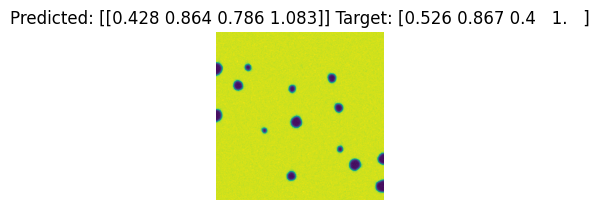

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt
net.load_state_dict(torch.load('/content/drive/MyDrive/MagDomWeights/MagDom2paramHuber500epochR2filersize5_5.pth'))
img_path = '/content/drive/MyDrive/CroppedImages/train/'
list_img = os.listdir(img_path)[21]

img = Image.open(img_path + list_img)
if img.mode != 'RGB':
      img = img.convert('RGB')
values = list_img.split('_')
Ms = float(values[0].split('/')[-1])
Aex = float(values[1])
keff = float(values[2])
alpha = float(values[3])
maxMs = 1900000.0
maxAex = 2.4999999999999998e-11
maxkeff = 1000000.0
maxalpha = 0.95
target = np.array([Ms/maxMs, Aex/maxAex, keff/maxkeff, alpha/maxalpha])
target = np.round(target,3)
net.eval()
img = data_transforms['val'](img)
img = img.unsqueeze(0)
img = img.to(device)
with torch.no_grad():
      outputs = net(img).cpu().detach().numpy()
      outputs  = np.round(outputs,3)
      ax = plt.subplot(2,2,1)
      ax.axis('off')
      ax.set_title(f'Predicted: {outputs} Target: {target}')
      plt.imshow(img.cpu().data[0].squeeze(0))


0
0


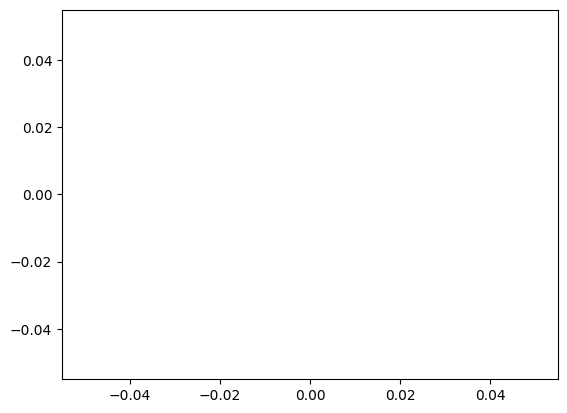

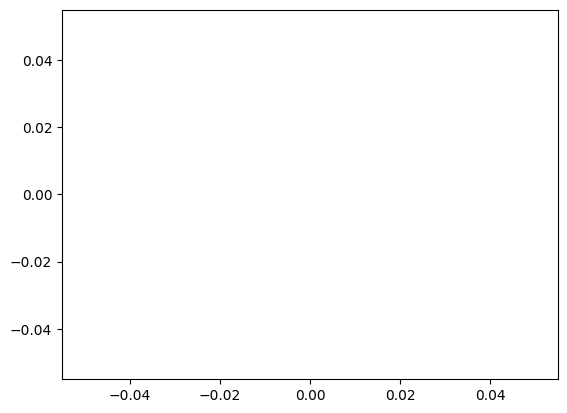

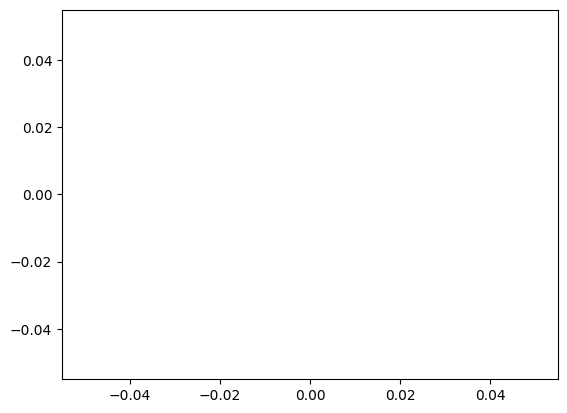

In [ ]:
from torch import is_tensor

x = np.arange(0,len(MAElist),1)
print(len(MAElist))
print(len(R2list))

for i in range(0,len(MAElist)):
  if is_tensor(R2list[i]):
    R2list[i] = R2list[i].item()
  if is_tensor(MAElist[i]):
    MAElist[i] = MAElist[i].item()
plt.scatter(x,R2list)
plt.show()
plt.scatter(x,MAElist)
plt.show()
plt.scatter(x,losslist)
plt.show()


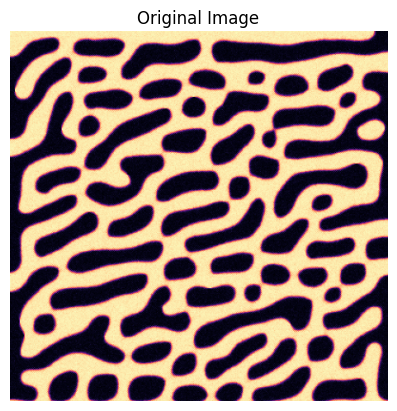

In [ ]:
# Load the image
from PIL import Image
import os
import matplotlib.pyplot as plt
img_path = '/content/drive/MyDrive/CroppedImages/train/'
list_img = os.listdir(img_path)[200]
input_image = Image.open(img_path+list_img) # add your image path
plt.imshow(input_image)
plt.axis("off")
plt.title('Original Image')
plt.show()


In [ ]:

net.load_state_dict(torch.load('/content/drive/MyDrive/MagDomWeights/MagDom2paramHuber500epochR2filersize5_5.pth'))


<All keys matched successfully>

In [ ]:
conv_weights = []  # List to store convolutional layer weights
conv_layers = []  # List to store convolutional layers
total_conv_layers = 0  # Counter for total convolutional layers
for i, layer in enumerate(net):
  print(f"Layer {i}: {layer}")
  if isinstance(layer, nn.Conv2d):
      total_conv_layers += 1
      conv_weights.append(layer.weight)
      conv_layers.append(layer)
print(conv_layers)
print(total_conv_layers)


Layer 0: Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
Layer 1: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 2: Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
Layer 3: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 4: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
Layer 5: AdaptiveAvgPool2d(output_size=(1, 1))
Layer 6: Flatten(start_dim=1, end_dim=-1)
Layer 7: Linear(in_features=128, out_features=256, bias=True)
Layer 8: Linear(in_features=256, out_features=128, bias=True)
Layer 9: Linear(in_features=128, out_features=64, bias=True)
Layer 10: Linear(in_features=64, out_features=4, bias=True)
[Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1)), Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))]
3


In [ ]:
# Preprocess the image and move it to GPU
input_image = data_transforms['val'](input_image)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Extract feature maps
feature_maps = []  # List to store feature maps
layer_names = []  # List to store layer names
for layer in conv_layers:
    input_image = layer(input_image)
    feature_maps.append(input_image)
    layer_names.append(str(layer))


In [ ]:


# Display feature maps shapes
print("\nFeature maps shape")
for feature_map in feature_maps:
    print(feature_map.shape)

# Process and visualize feature maps
processed_feature_maps = []  # List to store processed feature maps
for feature_map in feature_maps:
    feature_map = feature_map.squeeze(0)  # Remove the batch dimension
    mean_feature_map = torch.sum(feature_map, 0) / feature_map.shape[0]  # Compute mean across channels
    processed_feature_maps.append(mean_feature_map.data.cpu().numpy())



Feature maps shape
torch.Size([1, 32, 444, 444])
torch.Size([1, 64, 440, 440])
torch.Size([1, 128, 438, 438])



 Processed feature maps shape
(444, 444)
(440, 440)
(438, 438)


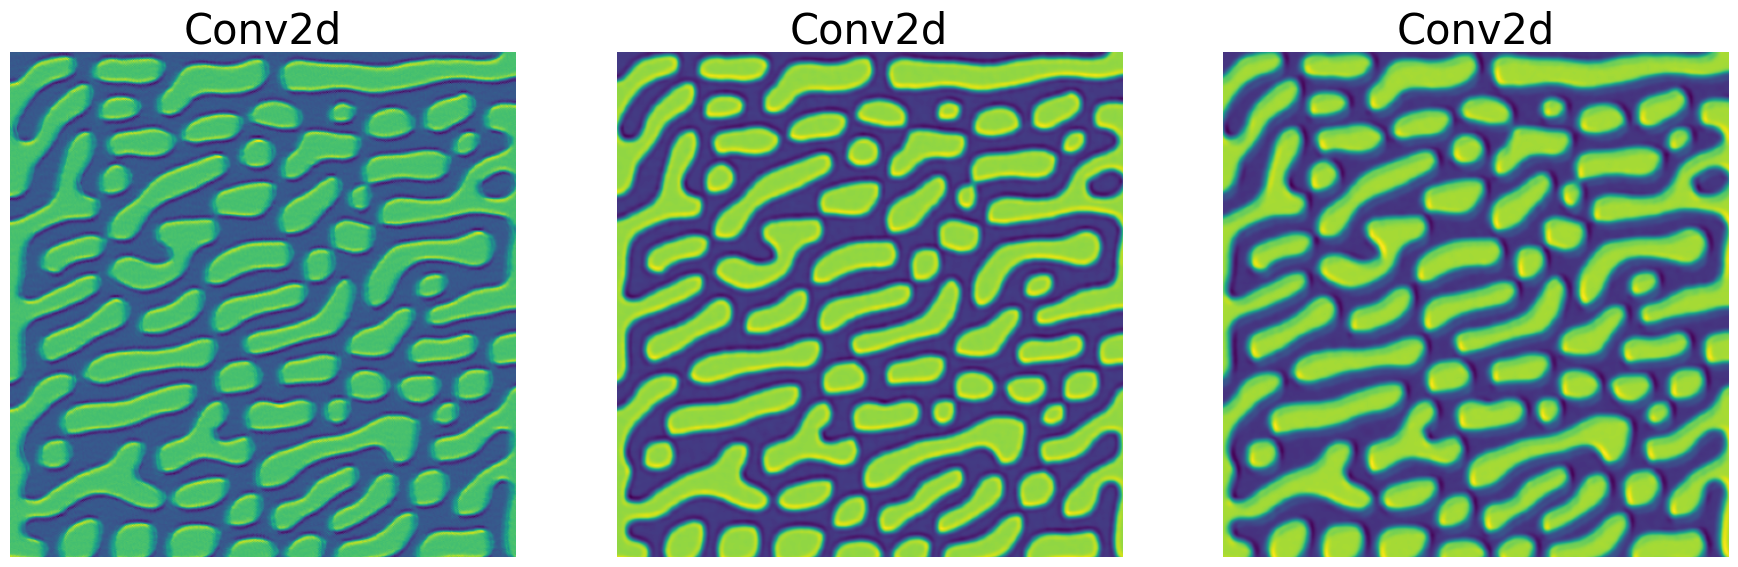

In [ ]:

# Display processed feature maps shapes
print("\n Processed feature maps shape")
for fm in processed_feature_maps:
    print(fm.shape)

# Plot the feature maps
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed_feature_maps)):
    ax = fig.add_subplot(5, 4, i + 1)
    ax.imshow(processed_feature_maps[i])
    ax.axis("off")
    ax.set_title(layer_names[i].split('(')[0], fontsize=30)
